# AOS DM-33104 : move mask away from donut

Use donuts from corner sensor simulation, with background 
    
    
    cd /project/scichris/aos/masks_DM-33104/wfs/
    mkdir quickbg/
    mkdir quickbg/vignette_test_175
    mkdir quickbg/vignette_test_177  
    mkdir quickbg/vignette_test_179
    mkdir quickbg/vignette_test_181
    mkdir quickbg/vignette_test_183
    
    cd quickbg
    
    mkdir vignette_test_175/phosimData
    ...
    
    rsync -rtvPh suberlak@epyc.astro.washington.edu:/astro/users/brycek/brycek_epyc/Commissioning/aos/ts_analysis_notebooks/aos/vignetting/quickbg/vignette_test_175/phosimData/ vignette_test_175/phosimData/


... this transfer is going very very slow, so instead run imgCloseLoop with a grid of isolated stars on each of the corner sensors. Bryce was using one star per simulation, but I can combine them and rerun. Run first with batoid to see what the donuts will look like (to ensure they're well-separated before I run the entire loop...).

The sky files are at  `/gscratch/astro/brycek/aos_runs/inputCatalogs/vignette` on `hyak`. Copy those to NCSA:

First, `ssh` to hyak to see what's available:

    ssh suberlak@mox.hyak.uw.edu
    cd /gscratch/astro/brycek/aos_runs/inputCatalogs/vignette
    ls

Then, from `NCSA` run scp:

    cd /project/scichris/aos/masks_DM-33104/wfs/
    scp suberlak@mox.hyak.uw.edu:/gscratch/astro/brycek/aos_runs/inputCatalogs/vignette/*.txt .


Imports

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
)
import os

from lsst.daf import butler as dafButler
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate




## Simulate with phosim and batoid using skyfiles with stars at varying distance from the center of the focal plane

Plot these files:

In [113]:
from astropy.table import Table
fpath = '/project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky.txt' 
#fpath = '/project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky-single-177.txt'
skyfile = Table.read(fpath, format='ascii')


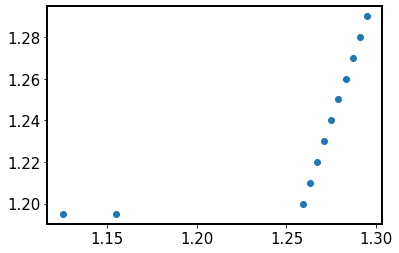

In [114]:
N=12

plt.scatter(skyfile['Ra'][:N], skyfile['Decl'][:N])
#plt.scatter(skyfile['Ra'][5], skyfile['Decl'][5])



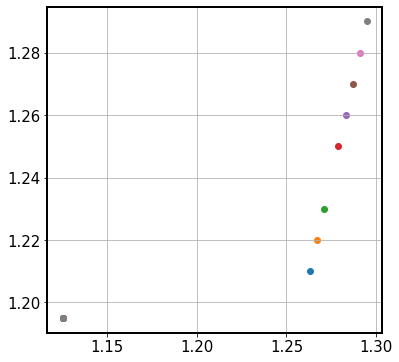

In [115]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for dist in [175,176,177,179,180,181, 182,183]:
    fpath = f'/project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky-single-{dist}.txt'
    skyfile = Table.read(fpath, format='ascii')
    ax.scatter(skyfile['Ra'][:2], skyfile['Decl'][:2])
ax.grid()

Simulate these with batoid (based on `cwfs-simulation` on `wfsim` notebooks):

In [2]:
import sys
sys.path.append('/project/scichris/aos/wfsim/')
import numpy as np
import yaml
from tqdm.notebook import tqdm
import galsim
import batoid
import wfsim
import matplotlib.pyplot as plt

In [40]:
rng = np.random.default_rng(5772156649015328606065120900824024310421)

# set up the fiducial telescope
bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
fiducial_telescope = batoid.Optic.fromYaml("LSST_r.yaml")
factory = wfsim.SSTFactory(fiducial_telescope)
pixel_scale = 10e-6

# Setup observation parameters.  Making ~plausible stuff up.
observation = {
    'zenith': 30 * galsim.degrees,
    'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
    'wavelength': bandpass.effective_wavelength,
    'exptime': 15.0,  # seconds
    'temperature': 293.,  # Kelvin
    'pressure': 69.,  #kPa
    'H2O_pressure': 1.0  #kPa
}

# Setup atmospheric parameters
atm_kwargs = {
    'screen_size': 819.2,
    'screen_scale': 0.1,
    'nproc': 6  # create screens in parallel using this many CPUs
}

# perturb the mirrors
dof = rng.normal(scale=0.1, size=50) # activate some M2 bending modes
dof[[28, 45, 46]] = 0 # but zero-out the hexafoil modes that aren't currently fit well.
telescope = factory.get_telescope(dof=dof)  # no perturbations yet


# now we simulate one (pair) of the corner wavefront sensors
# you set which pair by setting the raft.
# options are: R40 - R44
#               |     |
#              R00 - R04


In [74]:
raft = "R44"

# create the extrafocal simulator, i.e. the simulator for raft_SW0
extra = telescope.withGloballyShiftedOptic("Detector", [0, 0, +0.0015])
extra_simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    extra,
    bandpass,
    name=f"{raft}_SW0",
    rng=rng
)

# create the intrafocal simulator, i.e. the simulator for raft_SW1
intra = telescope.withGloballyShiftedOptic("Detector", [0, 0, -0.0015])
intra_simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    intra,
    bandpass,
    name=f"{raft}_SW1",
    rng=rng
)

In [75]:
# set the star properties
star_T = 8000
sed = wfsim.BBSED(star_T)
flux = 10_000_000

In [53]:
extra_bounds = extra_simulator.get_bounds()
intra_bounds = intra_simulator.get_bounds()

Text(0.5, 1.0, 'R44')

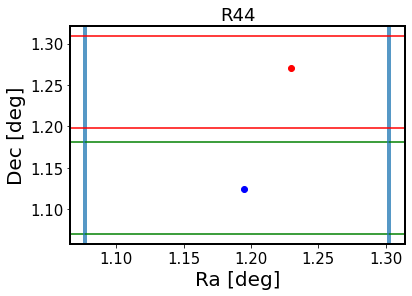

In [81]:
# plot the bounds and the skyfile sources
N=2
plt.scatter(skyfile['Decl'][0], skyfile['Ra'][0],c='r')
plt.scatter(skyfile['Decl'][1], skyfile['Ra'][1],c='b')
#plt.scatter(skyfile['Ra'][5], skyfile['Decl'][5])
extra_bounds_deg = np.rad2deg(extra_bounds)
intra_bounds_deg = np.rad2deg(intra_bounds)

# extra bounds
xlims = extra_bounds_deg[0]
plt.axvline(xlims[0])
plt.axvline(xlims[1])
ylims =  extra_bounds_deg[1]
plt.axhline(ylims[0],c='g')
plt.axhline(ylims[1],c='g')

# intra bounds
xlims = intra_bounds_deg[0]
plt.axvline(xlims[0])
plt.axvline(xlims[1])
ylims =  intra_bounds_deg[1]
plt.axhline(ylims[0],c='r')
plt.axhline(ylims[1],c='r')

plt.xlabel('Ra [deg]')
plt.ylabel('Dec [deg]')

plt.title(raft)

In [82]:
i=0
intra_thx, intra_thy = np.deg2rad(skyfile['Decl'][i]), np.deg2rad(skyfile['Ra'][i])
i=1
extra_thx, extra_thy = np.deg2rad(skyfile['Decl'][i]), np.deg2rad(skyfile['Ra'][i])

In [76]:
# I need to invert the Ra/ Decl  
# compared to phoSim
for i in range(2):
    thx = np.deg2rad(skyfile['Decl'][i])
    thy = np.deg2rad(skyfile['Ra'][i])
    print(f'Simulating star {i}, ra,dec [rad]={thx,thy}')
    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)

Simulating star 0, ra,dec [rad]=(0.021467549799530253, 0.022183134792847926)
Simulating star 1, ra,dec [rad]=(0.020856684561332238, 0.019634954084936207)


In [78]:
# add the sky background
extra_simulator.add_background(1000.0, rng)
intra_simulator.add_background(1000.0, rng)

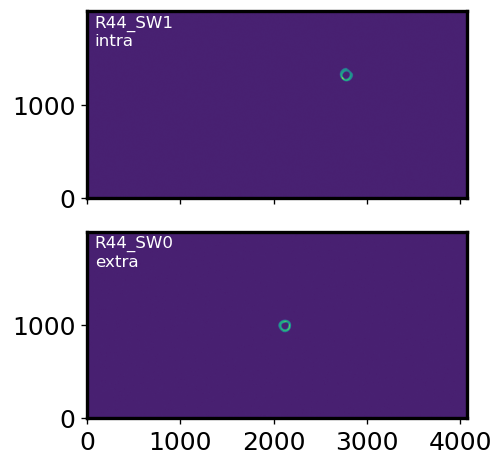

In [79]:
# now we will plot the two chips

# first set up the figure and axes
# get horizontal/vertical orientation correct
if raft[1] == raft[2]:
    fix, axes = plt.subplots(ncols=1, nrows=2, figsize=(4, 4), sharex=True, sharey=True, dpi=120)
else:
    fix, axes = plt.subplots(ncols=2, nrows=1, figsize=(4, 4), sharex=True, sharey=True, dpi=120)
# make sure extrafocal chip is closer to center of focal plane
if raft[1] == "4":
    axes = axes[::-1]

# plot the extrafocal chip
axes[0].imshow(extra_simulator.image.array, origin="lower")
axes[0].text(
    0.02, 0.98, 
    f"{extra_simulator.sensor_name}\nextra", 
    transform=axes[0].transAxes, 
    ha="left", va="top", 
    c="w",
)

# plot the intrafocal chip
axes[1].imshow(intra_simulator.image.array, origin="lower")
axes[1].text(
    0.02, 0.98, 
    f"{intra_simulator.sensor_name}\nintra", 
    transform=axes[1].transAxes, 
    ha="left", va="top", 
    c="w",
)

plt.tight_layout()
plt.show()

In [ ]:
for i in range(2):
    thx = np.deg2rad(skyfile['Decl'][i])
    thy = np.deg2rad(skyfile['Ra'][i])

In [ ]:
extra_thx = 

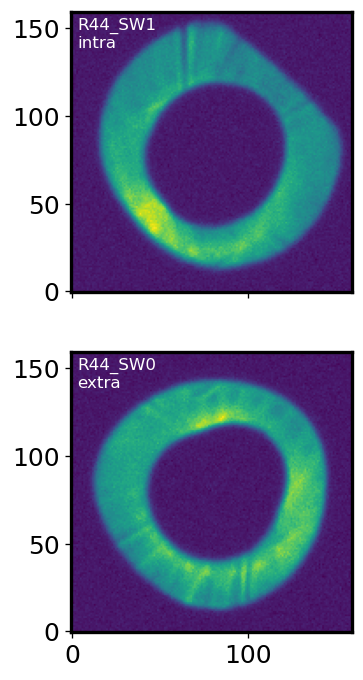

In [88]:
# now we will crop the donuts 

# first set up the figure and axes
# get horizontal/vertical orientation correct
if raft[1] == raft[2]:
    fix, axes = plt.subplots(ncols=1, nrows=2, figsize=(3, 6), sharex=True, sharey=True, dpi=120)
else:
    fix, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3), sharex=True, sharey=True, dpi=120)
# make sure extrafocal chip is closer to center of focal plane
if raft[1] == "4":
    axes = axes[::-1]

# plot the extrafocal image
x, y = extra_simulator.wcs.radecToxy(extra_thx, extra_thy, galsim.radians) # donut center in x/y coords
x = int(x - extra_simulator.image.bounds.xmin) # x in image coords
y = int(y - extra_simulator.image.bounds.ymin) # y in image coords

half = 80 # 128
extra_img = extra_simulator.image.array[y-half:y+half, x-half:x+half] # cut out the donut
axes[0].imshow(extra_img, origin="lower")
axes[0].text(
    0.02, 0.98, 
    f"{extra_simulator.sensor_name}\nextra", 
    transform=axes[0].transAxes, 
    ha="left", va="top", 
    c="w",
)


# plot the intrafocal image
x, y = intra_simulator.wcs.radecToxy(intra_thx, intra_thy, galsim.radians)
x = int(x - intra_simulator.image.bounds.xmin) # x in image coords
y = int(y - intra_simulator.image.bounds.ymin) # y in image coords
intra_img = intra_simulator.image.array[y-half:y+half, x-half:x+half] # cut out the donut
axes[1].imshow(intra_img, origin="lower")
axes[1].text(
    0.02, 0.98, 
    f"{intra_simulator.sensor_name}\nintra", 
    transform=axes[1].transAxes, 
    ha="left", va="top", 
    c="w",
)

plt.tight_layout()
plt.show()

In [89]:
# CWFS config
cwfsConfigDir = os.path.join(getConfigDir(), "cwfs")
instDir = os.path.join(cwfsConfigDir, "instData")
inst = Instrument(instDir)
algoDir = os.path.join(cwfsConfigDir, "algo")

# run zernike estimation using the FFT algorithm
# I_extra = CompensableImage()
# I_extra.setImg(np.rad2deg([extra_thx, extra_thy]), DefocalType.Extra, image=extra_img.copy())

# I_intra = CompensableImage()
# I_intra.setImg(np.rad2deg([intra_thx, intra_thy]), DefocalType.Intra, image=intra_img.copy())
              
# inst.config(CamType.LsstFamCam, I_extra.getImgSizeInPix(), announcedDefocalDisInMm=1.5)

# fftAlgo = Algorithm(algoDir)
# fftAlgo.config("fft", inst)          
# fftAlgo.runIt(I_intra, I_extra, "offAxis", tol=1e-3)
# fft_zk = fftAlgo.getZer4UpInNm()

# run zernike estimation using the Exp algorithm
# There's probably a reset method somewhere, but it's fast enough to just
# reconstruct these...
I_extra = CompensableImage()
I_extra.setImg(np.rad2deg([extra_thx, extra_thy]), DefocalType.Extra, image=extra_img.copy())

I_intra = CompensableImage()
I_intra.setImg(np.rad2deg([intra_thx, intra_thy]), DefocalType.Intra, image=intra_img.copy())
              
inst.config(CamType.LsstCam, I_extra.getImgSizeInPix(), announcedDefocalDisInMm=1.5)

expAlgo = Algorithm(algoDir)
expAlgo.config("exp", inst)          
expAlgo.runIt(I_intra, I_extra, "offAxis", tol=1e-3)
exp_zk = expAlgo.getZer4UpInNm()

In [90]:
# get the true zernikes at the center of the corner wavefront chip
center_thx, center_thy = np.hstack((extra_bounds, intra_bounds)).mean(axis=1)
bzk = batoid.zernike(telescope, center_thx, center_thy, 622e-9, eps=0.61)
# convert wave -> nm
bzk *= 622

 4  -463.755 nm  -570.217 nm
 5   775.225 nm  -393.388 nm
 6   511.974 nm   231.330 nm
 7  -122.453 nm   -28.986 nm
 8  -441.460 nm  -420.325 nm
 9  -151.202 nm     3.860 nm
10  -458.781 nm  -309.305 nm
11   -31.948 nm   -36.354 nm
12    72.040 nm   169.366 nm
13   -66.851 nm    38.164 nm
14   -49.465 nm   234.303 nm
15  -243.708 nm  -154.998 nm
16    36.626 nm     0.946 nm
17  -123.043 nm  -197.213 nm
18   141.227 nm   257.291 nm
19  -165.475 nm  -315.855 nm
20   -32.635 nm    25.215 nm
21  -188.919 nm  -122.709 nm
22    -5.036 nm    -7.319 nm


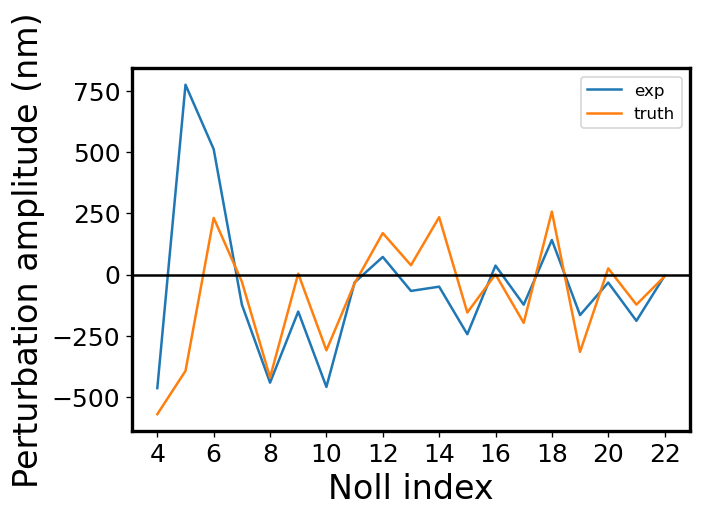

In [91]:
from matplotlib.ticker import MaxNLocator
# print all the zernikes
for i in range(4, 23):
    print(f"{i:2}  {exp_zk[i-4]:8.3f} nm  {bzk[i]:8.3f} nm")

fig, ax = plt.subplots(dpi=120)
ax.plot(range(4, 23), exp_zk, label='exp')
ax.plot(range(4, 23), bzk[4:], label='truth')
plt.axhline(0, c='k')

ax.legend()

ax.set(xlabel="Noll index", ylabel="Perturbation amplitude (nm)")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

One interesting thing (at least here) is that the batoid donuts look nothing like the phosim donuts.. That could be due to different perturbations imparted, etc.. 

Submit this exact skyfile to phosim:

    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 230 --boresightDeg 0.0 0.0  --output /project/scichris/aos/masks_DM-33104/wfs/vignette177/ --skyFile /project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky-single-177.txt
    
as `wfs177` job to slurm.

- Check the progress with 

    more slurm-60766.out 
    
- Just one iteration is all that I need given that ...  
- that's w/o background....


/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/

Add background by pointing to a different cmd file:

    cd /project/scichris/aos/masks_DM-33104/wfs
cp /project/scichris/aos/ts_phosim/policy/cmdFile/starDefault.cmd .
cp starDefault.cmd starDefaultQckBg.cmd
nano starDefaultQckBg.cmd
--> change `backgroundmode 0` to  `quickbackground` 
--> save as `starDefaultQckBg.cmd`

Want to run `imgCloseLoop` with 

    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 230 --boresightDeg 0.0 0.0  --output /project/scichris/aos/masks_DM-33104/wfs/vignette177qckBg/ --skyFile /project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky-single-177.txt    --iterNum 1 --cmdFile ....

But I can't submit different `cmdFile` (!) - there's no such kwarg in `imgCloseLoop` ...

The only was seems to be to modify the `policy/cmdFile/starDefault.cmd` file itself, unfortunately. 

So I do 

    nano /project/scichris/aos/ts_phosim/policy/cmdFile/starDefault.cmd 

--> change `backgroundmode 0` to  `quickbackground` 

And now run with 

    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 230 --boresightDeg 0.0 0.0  --output /project/scichris/aos/masks_DM-33104/wfs/vignette177qckBg/ --skyFile /project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky-single-177.txt    --iterNum 1 


--------

---------

Also, run `quickbackground` simulating all stars at once so I have more donut pairs ....

    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 230 --boresightDeg 0.0 0.0  --output /project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/ --skyFile /project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky.txt    --iterNum 1  


In [2]:
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate


def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog


def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId, 
                          collections=[collection])
    return postIsr



### [ASIDE]: Debugging raws ... 

In [41]:
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006001'
iterN=0
sensor = 'R00'

raws = {}
for i in range(2):
    detector=f"{sensor}_SW{i}"
    collection = 'LSSTCam/raw/all'
    butler = dafButler.Butler(repo_dir)
    registry = butler.registry

    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='raw',
                            dataId=dataId0, 
        collections= [collection]
                            )
                       ))
    expN = dataset.dataId["exposure"]
    print(expN)
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    raws[detector] = butler.get('raw',dataId=dataId, 
                          collections=[collection])


    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    raw = butler.get('raw',dataId=dataId, 
                          collections=[collection])
    raws[detector] = raw

4022010106000
4022010106000


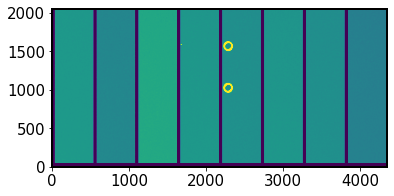

In [39]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
data = raws['R00_SW0'].image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, origin='lower', vmin=vmin, vmax=vmax)


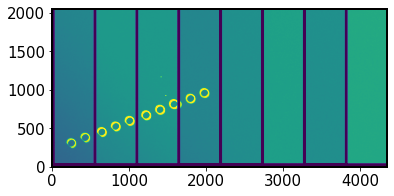

In [37]:
data = raws['R00_SW1'].image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

What happens when  I try to just query to do the postISR part:
    
    
    pipetask run -b /project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData -i refcats,LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run ts_phosim_9006000 -p /project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/lsstPipeline.yaml -d "exposure IN (4021123106000)" -j 20

Find out what's in that butler ... 

    butler query-data-ids . exposure visit --where "instrument='LSSTCam'  and exposure=4022010106000"

It does provide 

    band instrument physical_filter    exposure       visit    
    ---- ---------- --------------- ------------- -------------
       g    LSSTCam               g 4022010106000 4022010106000
    
so what's going on??



Ok, run manually with the correct exposure number (jsut for  `qckBg`, as I don't think `sunalt -90` is gonna change anything ...)
    
                                                   but can run that just to be sure 
    

    pipetask run -b /project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData -i refcats,LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run ts_phosim_9006000 -p /project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/lsstPipeline.yaml -d "exposure IN (4022010106000)" -j 20
    
    
    pipetask run -b /project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBgSunAlt/phosimData -i refcats,LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run ts_phosim_9006000 -p /project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBgSunAlt/phosimData/lsstPipeline.yaml -d "exposure IN (4022010106000)" -j 20

## Show the postISR and donut stamps... 

In [62]:
# Load the stamps
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

intraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)
pixelScaleArcsec = extraImage.getWcs().getPixelScale().asArcseconds()


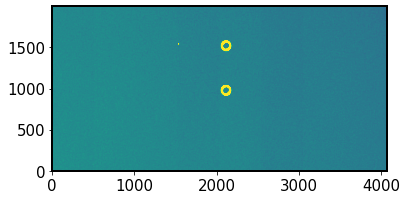

In [63]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
data = extraImage.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, origin='lower', vmin=vmin, vmax=vmax)


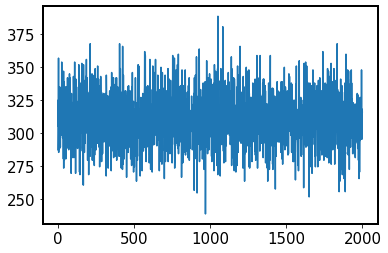

In [64]:
plt.plot(data[:,1000])

In [65]:
# I find the background level to be basically the same between  having `sunalt -90` and not having it ... 
np.mean(data[:,1000])


311.0531

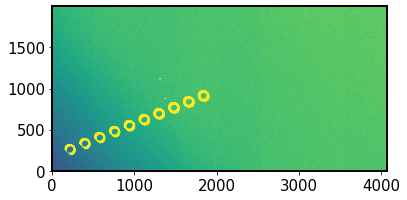

In [44]:
data = intraImage.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, origin='lower', vmin=vmin, vmax=vmax)


ok - I initially got no stars because of the MJD. With the current MJD of 59580 it brings too much twilight :
    
 
    

In [1]:
from astropy.time import Time
t = Time('59580', format='mjd')

In [5]:
t.datetime.isoformat()

'2022-01-01T00:00:00'

ok, so that's the time in UTC (midnight). But in Chile, it is UTC-4, i.e. it is 8 pm , which is not dark enough...


Set the time to 59580.5:

In [11]:
t = Time('59580.15', format='mjd')

t.datetime.isoformat()

'2022-01-01T03:36:00'

So that's going to be~ 11:30 pm in Chile. Probably dark enough ... Rerun the simulation! 

But how do I change the simulation time? 



It's hard-coded in `teleSetting.yaml`... Need to edit that (from `59580` to `59580.5`), together with `starDefault.cmd` (to `quickbackground`) , and see ehat happens 



## Inspect donut stamps 

 I can  just plot all the intra-focal stamps to ensure they're well-isolated:

nIntra=10, nExtra=2


Text(0.5, 1.0, 'R00 intra')

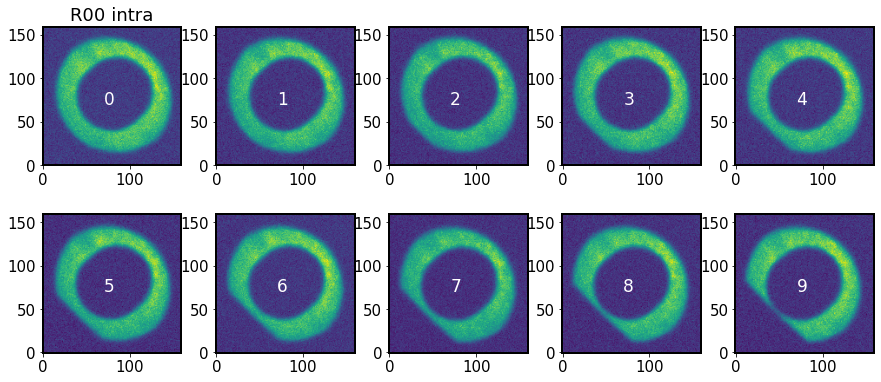

In [55]:
%matplotlib inline

nIntra = len(donutStampsIntra)
nExtra = len(donutStampsExtra)
print(f'nIntra={nIntra}, nExtra={nExtra}')
nDonuts = nIntra
ncols = 5
nrows = nDonuts // ncols

fig, axs  = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
ax = np.ravel(axs)

for i in range(nIntra):
    ax[i].imshow(donutStampsIntra[i].stamp_im.image.array, origin='lower')
    ax[i].text(70,70, f'{i}', fontsize=17, c='white')
    
fig.subplots_adjust(hspace=0.35)  
ax[0].set_title(f'{sensor} intra')
#fig.suptitle(sensor, fontsize=20)

#plt.savefig(f'{sensor}_donuts.png', bbox_inches='tight')

Those are pairs of donuts that would normally get selected for analysis:

10 2


Text(0.5, 1.0, 'R00 extra')

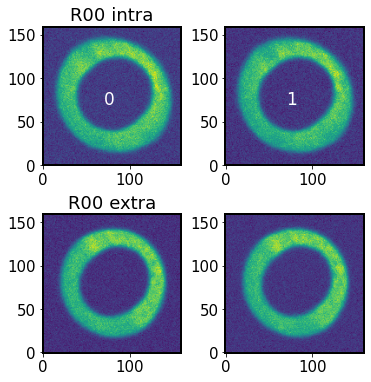

In [56]:
%matplotlib inline

nIntra = len(donutStampsIntra)
nExtra = len(donutStampsExtra)
print(nIntra,nExtra)
nDonuts = min(nIntra, nExtra)
ncols = 2
nrows = nDonuts

fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for i in range(nDonuts):
    ax[0,i].imshow(donutStampsIntra[i].stamp_im.image.array, origin='lower')
    ax[1,i].imshow(donutStampsExtra[i].stamp_im.image.array, origin='lower')
    ax[0,i].text(70,70, f'{i}', fontsize=17, c='white')
    
fig.subplots_adjust(hspace=0.35)  
ax[0,0].set_title(f'{sensor} intra')
ax[1,0].set_title(f'{sensor} extra')
#fig.suptitle(sensor, fontsize=20)
#plt.savefig(f'{sensor}_donuts.png', bbox_inches='tight')

So the plan,  instead of going donut pair to donut pair, is to always use extra-focal  donut 1, and for intra-focal keep switching...

## Grid of dx,dy : vary fieldXYExtra, fieldXYIntra

Do the experiment of offsetting where the mask is calculated for in a grid of dx, dy. First change for the extra-focal donut only, then change from intra-focal donut only. 

In [3]:
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate


### Step 1:  load the stamps 

In [5]:
#################################
### STEP 1 :  Load the stamps
#################################

repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# now instead of calling 
# wfEsti = WfEstimator(instDir, algoDir)
# I dig inside it 

# this is part of the init 
inst = Instrument(instDir)
algo = Algorithm(algoDir)

#imgIntra = CompensableImage()
#imgExtra = CompensableImage()

#opticalModel = ""
#sizeInPix = 0

# now get the camera type and defocal distance
# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
# https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L134
instName='lsst'    
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# now instead of calling 
# wfEsti.config( sizeInPix=self.donutStampSize, camType=camType,
#                opticalModel=self.opticalModel, defocalDisInMm=defocalDisInMm,
# )

# I update the parameters 
opticalModel = 'offAxis'
# Update the instrument name
#donutStampSize = 160 # px 
#sizeInPix = donutStampSize
sizeInPix = 160# int(sizeInPix)

inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm 
solver = 'exp' # by default 
debugLevel=0 # 1 to 3 
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

###
# now we'd normally loop over donut images 
###




In [6]:
print(sensor)

R00


Now, instead of choosing i-th extra, and i-th intra-focal donut, I will always choose the first extra-focal, but vary the intra-focal 

### ASIDE : look at mask at each step. 

In [19]:
## ASIDE : look at mask at each step. 

# - before algo run 
# - after algo run 

# is it better to store the entire compensable image? or call  mask_comp and mask_pupil ?  



In [28]:
msks = {}

i = 0 
#for i in range(len(donutStampsIntra)):
#for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
donutExtra = donutStampsExtra[0]
donutIntra = donutStampsIntra[i]
print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')

fieldXYExtra = donutExtra.calcFieldXY()
fieldXYIntra = donutIntra.calcFieldXY()

#######################################
### STEP 2 A : fit baseline (no offset)
#######################################

camera = donutExtra.getCamera()
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)

# Rotate any sensors that are not lined up with the focal plane.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

# Now instead of running `wfEsti.setImg` method, do it by hand, since 
# it inherits 'setImg' from 'CompensableImage' anyway...
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

    
# m1 :  evaluate before fit
# right after we set the image, the compensable image mask is empty - 
# it is only calculated in algo
# https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
maskScalingFactorLocal = 1
boundaryT = algo.getBoundaryThickness()
imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

msks['before']={'imgIntra':imgIntra, 'imgExtra':imgExtra}



# now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
algo.reset()

# now wfEsti.calWfsErr() after checking for image size (both need to be squares)
# simply calls algo:
tol = 1e-3 # explicitly set the tolerance level ( this is default )
algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
zk_no_offset = algo.getZer4UpInNm()

msks['after']={'imgIntra':imgIntra, 'imgExtra':imgExtra}



fname = f'{sensor}_donut_{i}_no_offset_zk.txt'
np.savetxt(fname, zk_no_offset)
print(f'\nSaved the baseline fit as {fname}')





 Fitting sensor R00, donutIntra 0, donutExtra 0 

Saved the baseline fit as R00_donut_0_no_offset_zk.txt


/tmp/ipykernel_3584760/1654490615.py:13: RuntimeWarning: invalid value encountered in true_divide
  ax[0,2].imshow(m2p/m1p)
/tmp/ipykernel_3584760/1654490615.py:22: RuntimeWarning: invalid value encountered in true_divide
  ax[1,2].imshow(m1n/m2n)


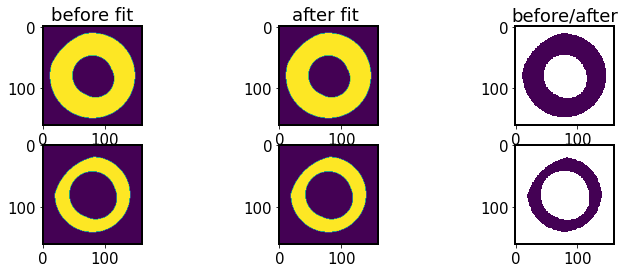

In [39]:
fig, ax = plt.subplots(2,3,figsize=(12,4))

ax[0,0].set_title('before fit')
m1p = msks['before']['imgIntra'].getPaddedMask()
ax[0,0].imshow(m1p)


ax[0,1].set_title('after fit ')
m2p = msks['after']['imgIntra'].getPaddedMask()
ax[0,1].imshow(m2p)

ax[0,2].set_title('before/after')
ax[0,2].imshow(m2p/m1p)


m1n = msks['before']['imgIntra'].getNonPaddedMask()
m2n = msks['after']['imgIntra'].getNonPaddedMask()
ax[1,0].imshow(m1n)

ax[1,1].imshow(m2n)

ax[1,2].imshow(m1n/m2n)


In [42]:
np.sum(m1p - m2p)

0

So they're the same, i.e it doesn't matter whether we evaluate the masks before or after fitting 

### Step 2 : Loop over donut pairs 

In [48]:
#######################################
### STEP 2 :  Loop over donut pairs 
#######################################

# run those where I got weird results from the 
# adaptive circle of diffRms threshold 
for i in range(len(donutStampsIntra)):
    #for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
    donutExtra = donutStampsExtra[0]
    donutIntra = donutStampsIntra[i]
    print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')

    fieldXYExtra = donutExtra.calcFieldXY()
    fieldXYIntra = donutIntra.calcFieldXY()

    #######################################
    ### STEP 2 A : fit baseline (no offset)
    #######################################

    camera = donutExtra.getCamera()
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)

    # Rotate any sensors that are not lined up with the focal plane.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # Now instead of running `wfEsti.setImg` method, do it by hand, since 
    # it inherits 'setImg' from 'CompensableImage' anyway...
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)
    
    # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
    algo.reset()

    # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
    # simply calls algo:
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
    zk_no_offset = algo.getZer4UpInNm()

    # store the compensable image, calculate the differences later .....
    
    baseline = {}
    baseline['imgIntra'] = imgIntra
    baseline['imgExtra'] = imgExtra
    baseline['zks'] = zk_no_offset
    
    fname = f'{sensor}_donut_{i}_no_offset_zk.npy'
    #np.savetxt(fname, zk_no_offset)
    np.save(fname, baseline)
    print(f'\nSaved the baseline fit (as well as imgIntra, imgExtra) as {fname}')
    




 Fitting sensor R00, donutIntra 0, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_0_no_offset_zk.npy

 Fitting sensor R00, donutIntra 1, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_1_no_offset_zk.npy

 Fitting sensor R00, donutIntra 2, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_2_no_offset_zk.npy

 Fitting sensor R00, donutIntra 3, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_3_no_offset_zk.npy

 Fitting sensor R00, donutIntra 4, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_4_no_offset_zk.npy

 Fitting sensor R00, donutIntra 5, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_5_no_offset_zk.npy

 Fitting sensor R00, donutIntra 6, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_6_no_offset_zk.npy

 Fitting sensor R00, donutIntra 7

In [44]:
#######################################
### STEP 2 :  Loop over donut pairs 
#######################################

# run those where I got weird results from the 
# adaptive circle of diffRms threshold 
for i in range(len(donutStampsIntra)):
    #for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
    donutExtra = donutStampsExtra[0]
    donutIntra = donutStampsIntra[i]
    print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')

    fieldXYExtra = donutExtra.calcFieldXY()
    fieldXYIntra = donutIntra.calcFieldXY()

    #######################################
    ### STEP 2 A : fit baseline (no offset)
    #######################################

    camera = donutExtra.getCamera()
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)

    # Rotate any sensors that are not lined up with the focal plane.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # Now instead of running `wfEsti.setImg` method, do it by hand, since 
    # it inherits 'setImg' from 'CompensableImage' anyway...
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)
    
    # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
    algo.reset()

    # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
    # simply calls algo:
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
    zk_no_offset = algo.getZer4UpInNm()

    # store the compensable image, calculate the differences later .....
    
    baseline = {}
    baseline['imgIntra'] = imgIntra
    baseline['imgExtra'] = imgExtra
    baseline['zks'] = zk_no_offset
    
    fname = f'{sensor}_donut_{i}_no_offset_zk.npy'
    #np.savetxt(fname, zk_no_offset)
    np.save(fname, baseline)
    print(f'\nSaved the baseline fit (as well as imgIntra, imgExtra) as {fname}')
    

    #######################################
    ### STEP 2 B : fit grid of dx, dy offset 
    #######################################

    ## First applying change to the extra-focal mask, and then to the intra-focal mask
    for defocal in ['intra','extra']: # or extra 
        print(f'Shifting the centroid for {defocal}-donut in that pair ')
        zk0 = zk_no_offset

        dxInPixels = np.linspace(-100,100,5)
        dyInPixels = dxInPixels

        dxInDegrees = (dxInPixels* pixelScale) / 3600
        dyInDegrees = (dyInPixels* pixelScale) / 3600

        results = {}
        j =0 
        
        for dxDeg in dxInDegrees:
            for dyDeg in dyInDegrees:
                
                # calculate radial offset
                radialOffsetDegrees = np.sqrt(dxDeg**2.0+dyDeg**2.0)

                # convert the x,y offset of the mask from degrees to pixels via pixelScale
                radialOffsetPixels = ( radialOffsetDegrees * 3600 )/pixelScale

                dxPx = (dxDeg * 3600) / pixelScale
                dyPx = (dyDeg * 3600) / pixelScale
                
                results[j] = {'dxDeg':dxDeg, 'dyDeg':dyDeg, 
                              'dxPx':dxPx, 'dyPx':dyPx, 
                              'drDeg':radialOffsetDegrees,
                              'drPx':radialOffsetPixels, 
                              }

                 # do the fit 
                if defocal == 'extra':
                    fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, fieldXYExtra[1]+dyDeg)
                    fieldXYIntraUpd = fieldXYIntra

                elif defocal =='intra':
                    fieldXYExtraUpd = fieldXYExtra
                    fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, fieldXYIntra[1]+dyDeg)

                imgExtra.setImg(fieldXYExtraUpd,
                                DefocalType.Extra,
                                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

                imgIntra.setImg(fieldXYIntraUpd,
                                DefocalType.Intra,
                                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


                # right after we set the image, the compensable image mask is empty - 
                # it is only calculated in algo
                # https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
                maskScalingFactorLocal = 1
                boundaryT = algo.getBoundaryThickness()
                imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
                imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

                # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
                algo.reset()

                # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
                # simply calls algo:
                tol = 1e-3 # explicitly set the tolerance level ( this is default )
                algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)
                zk = algo.getZer4UpInNm()
                
                # store imgIntra, imgExtra 
                results[j]['imgExtra'] = imgExtra
                results[j]['imgIntra'] = imgIntra
                
                # calculate diffMax, diffRms
                diffMax = np.max(np.abs(zk - zk0))
                diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

                # store the results 
                results[j]['diffMax'] = diffMax
                results[j]['diffRms'] = diffRms
                results[j]['zk'] = zk
                results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
                results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()

                # increase the grid counter 
                j += 1 
                print(j, dxPx, dyPx, diffRms, )
        fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_square_grid_N.npy'
        print(f"saved {fname}")
        np.save(fname, results)




 Fitting sensor R00, donutIntra 0, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_0_no_offset_zk.txt
Shifting the centroid for intra-donut in that pair 
1 -100.0 -100.0 5.418224660593058
2 -100.0 -50.0 4.536313660948304
3 -100.0 0.0 2.8201673041820743
4 -100.0 50.0 1.78869708137205
5 -100.0 100.0 1.2245643636054393
6 -50.0 -100.0 4.734461674054629
7 -50.0 -50.0 2.926096109080072
8 -50.0 0.0 1.521777597389053
9 -50.0 50.0 0.6586871964623618
10 -50.0 100.0 2.184019245403175
11 0.0 -100.0 3.5541951068725917
12 0.0 -50.0 2.594715940544722
13 0.0 0.0 0.0
14 0.0 50.0 1.9852001936898958
15 0.0 100.0 2.7200635226656282
16 50.0 -100.0 2.8007807409607155
17 50.0 -50.0 0.6911480148771966
18 50.0 0.0 2.055423546752788
19 50.0 50.0 2.568253702061847
20 50.0 100.0 2.721940040983434
21 100.0 -100.0 1.238687961350716
22 100.0 -50.0 1.6844770861491833
23 100.0 0.0 2.6701093998419374
24 100.0 50.0 2.6001990515355824
25 100.0 100.0 3.9976302776284554
saved R00_donut_0

KeyboardInterrupt: 

Calculate the mask difference between offsets. Plot diffRms as a function of mask difference ..

when we move intra-image centroid, the only thing that should change would be the intra-mask. the extra-mask should not change at all, but we can verify that . 

In [6]:
# read the data


# baseline , i.e. no offset 
sensor = 'R00'
defocal = 'extra'
i = 0 # the intra-focal donut that's moved 

fname = f'{sensor}_donut_{i}_no_offset_zk.npy'
baseline = np.load(fname,allow_pickle=True).item()

m0inP = baseline['imgIntra'].getNonPaddedMask()
m0inC = baseline['imgIntra'].getPaddedMask()
im0in = baseline['imgIntra'].getImg()

m0exP = baseline['imgExtra'].getNonPaddedMask()
m0exC = baseline['imgExtra'].getPaddedMask()
im0ex = baseline['imgExtra'].getImg()

# offsets 

fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_square_grid_N.npy'
results = np.load(fname, allow_pickle=True).item()


In [7]:
# move the mask when constructing the compensable image
# this affects the image, because the image
# gets "corrected" so it's slightly different

j = 0
m1inP = results[j]['imgIntra'].getNonPaddedMask()
m1inC = results[j]['imgIntra'].getPaddedMask()
im1in = results[j]['imgIntra'].getImg()

m1exP = results[j]['imgExtra'].getNonPaddedMask()
m1exC = results[j]['imgExtra'].getPaddedMask()
im1ex = results[j]['imgExtra'].getImg()

drPx = results[j]['drPx']
diffRms = results[j]['diffRms']

Difference in compensable donut image between baseline and shifted extra-focal mask.

Both intra (unmoved) and extra (shifted) are different between baseline (0) and shifted (1), because compensable image gets corrected for the distance from the focal plane. 

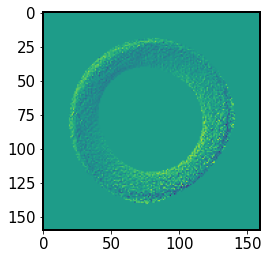

In [9]:
plt.imshow(im0ex-im1ex)

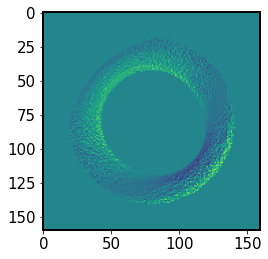

In [8]:
plt.imshow(im0in-im1in)

In [ ]:
So the image between being declared and the end of the algorithm run is different...

0
0
-6
-2


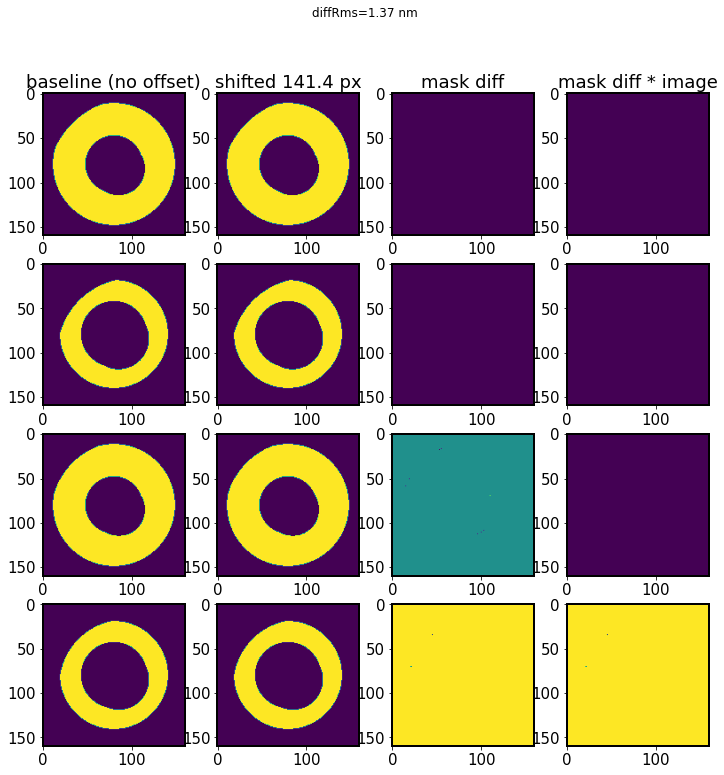

In [11]:
fig, ax = plt.subplots(4,4,figsize=(12,12))

fig.suptitle(f'diffRms={diffRms:.2f} nm')
#ax[row,col]

# first col 
ax[0,0].set_title('baseline (no offset)')
ax[0,0].imshow(m0inC)   # intra comp 
ax[1,0].imshow(m0inP) # intra pupil
ax[2,0].imshow(m0exC) # extra comp
ax[3,0].imshow(m0exP) # extra pupil

# second col
ax[0,1].set_title(f'shifted {drPx:.1f} px')
ax[0,1].imshow(m1inC) # intra comp
ax[1,1].imshow(m1inP) # intra pupil 
ax[2,1].imshow(m1exC) # extra comp
ax[3,1].imshow(m1exP) # extra pupil

# third col 
ax[0,2].set_title('mask diff')
mInCdiff = m0inC-m1inC
ax[0,2].imshow(mInCdiff)
print(np.sum(mInCdiff))

mInPdiff = m0inP-m1inP
ax[1,2].imshow(mInPdiff)
print(np.sum(mInPdiff))

mExCdiff = m0exC-m1exC
ax[2,2].imshow(mExCdiff)
print(np.sum(mExCdiff))

mExPdiff = m0exP-m1exP
ax[3,2].imshow(mExPdiff)
print(np.sum(mExPdiff))

# fourth col : diff * image 

ax[0,3].set_title('mask diff * image')
ax[0,3].imshow(mInCdiff*im0in)
ax[1,3].imshow(mInPdiff*im0in)
ax[2,3].imshow(mExCdiff*im1ex)
ax[3,3].imshow(mExPdiff*im1ex)

In [ ]:
m0exP

In [24]:
np.sum(m0inP-m1inP)

0

Plot the results 



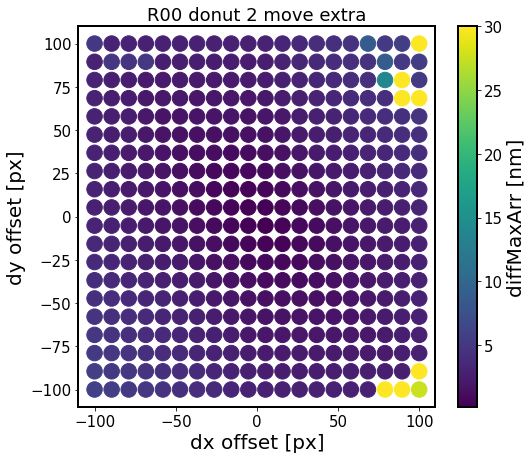

In [15]:
# read the data
sensor = 'R00'
defocal = 'extra'
i = 2
fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_square_grid.npy'
results = np.load(fname, allow_pickle=True).item()

# convert to continuous arrays
diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPxArr.append(results[j]['dxPx'])
    dyPxArr.append(results[j]['dyPx'])
    diffMaxArr.append(results[j]['diffMax'])
    diffRmsArr.append(results[j]['diffRms'])

    

fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffMaxArr, s=240,
               vmax=30)
#ax.hexbin(dxPxArr,dyPxArr,C=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}')
plt.colorbar(sc, label = 'diffMaxArr [nm]')

## Need to quantify the degree of the mask change. When to evaluate ? 

## Calculate the diffRms only along the increasing radial distance from the focal plane 

i.e. dx=dy, or dx=-dy, etc, depending on which sensor ... 



In [62]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import os
from scipy.ndimage import rotate

from lsst.daf import butler as dafButler

from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage


def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog


def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId, 
                          collections=[collection])
    return postIsr



In [63]:
#################################
### STEP 1 :  Load the stamps
#################################

repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# now instead of calling 
# wfEsti = WfEstimator(instDir, algoDir)
# I dig inside it 

# this is part of the init 
inst = Instrument(instDir)
algo = Algorithm(algoDir)

#imgIntra = CompensableImage()
#imgExtra = CompensableImage()

#opticalModel = ""
#sizeInPix = 0

# now get the camera type and defocal distance
# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
# https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L134
instName='lsst'    
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# now instead of calling 
# wfEsti.config( sizeInPix=self.donutStampSize, camType=camType,
#                opticalModel=self.opticalModel, defocalDisInMm=defocalDisInMm,
# )

# I update the parameters 
opticalModel = 'offAxis'
# Update the instrument name
#donutStampSize = 160 # px 
#sizeInPix = donutStampSize
sizeInPix = 160# int(sizeInPix)

inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm 
solver = 'exp' # by default 
debugLevel = 0 # 1 to 3 
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

###
# now we'd normally loop over donut images 
###




check which it is for R00... Is it +x +y  to increase the radial distance ? Or is it something else? 

In [14]:
# first for R00 intra-focal 

for i in range(len(donutStampsIntra)):
    #donutExtra = donutStampsExtra[0]
    donutIntra = donutStampsIntra[i]
    #print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')

    #fieldXYExtra = donutExtra.calcFieldXY()
    fieldXYIntra = donutIntra.calcFieldXY()

    
    print(i, fieldXYIntra)


0 (-1.2010833333333335, -1.259888888888889)
1 (-1.211083333333333, -1.2638888888888886)
2 (-1.2210833333333333, -1.2679444444444445)
3 (-1.2310833333333333, -1.2719444444444443)
4 (-1.2411388888888888, -1.2759444444444443)
5 (-1.251138888888889, -1.2799444444444443)
6 (-1.2611388888888888, -1.2839444444444443)
7 (-1.2710833333333333, -1.2879444444444443)
8 (-1.2811388888888888, -1.2919444444444443)
9 (-1.2911388888888888, -1.2959444444444441)


In [ ]:
https://github.com/jmeyers314/wfsim/blob/main/notebooks/Focal%20Plane%20Coordinate%20Systems.ipynb

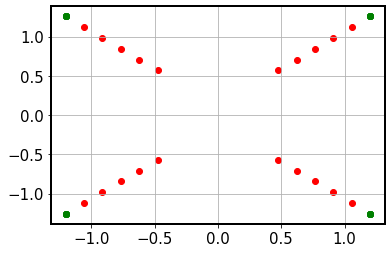

In [23]:
#Try coords of four corners, and see what would happen:
    
    
xy = [[-1.2010833333333335, -1.25988888888888],
      [-1.2010833333333335, +1.25988888888888],
      [+1.2010833333333335, -1.25988888888888],
      [+1.2010833333333335, +1.25988888888888]
     ]

dr = 0.2 # in radial direction

for i in range(len(xy)):
    for dr in np.linspace(0.2,1,5):
        x,y = xy[i]
        plt.scatter(x, y,c='g')
        tan = x/y
        dx = dr * (1 + tan**2.0)**(-0.5)
        dy = dr * (tan**2.0 / (1 + tan**2.0))**(0.5)
        #print(x,y, )

        nx = x - np.sign(x)*dx
        ny = y - np.sign(y)*dy
        #print(nx, ny )    
        plt.scatter(nx, ny,c='r')
#xs = np.linspace(-1.3,1.3)
#plt.plot(xs,xs)
plt.grid()

Ok ,so we start with green, and get progressively closer to the center of the focal plane - the code works. 

In [123]:
def get_nx_ny(x,y,dr):
    ''' Ontain new x, new y coordinate, 
    shifted by dr along radial direction.
    '''
    tan = x / y # y cannot be 0 
    dx = dr * (1 + tan**2.0)**(-0.5)
    dy = dr * (tan**2.0 / (1 + tan**2.0))**(0.5)

    # this ensures we shift away or toward the focal plane,
    # depending on dr and which quadrant we are in 
    nx = x - np.sign(x)*dx
    ny = y - np.sign(y)*dy
    
    return nx, ny 

#######################################
### STEP 2 :  Loop over donut pairs 
#######################################

# run those where I got weird results from the 
# adaptive circle of diffRms threshold 

for i in range(1,7):#len(donutStampsIntra)):
    #for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
    donutExtra = donutStampsExtra[0]
    donutIntra = donutStampsIntra[i]
    print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')

    fieldXYExtra = donutExtra.calcFieldXY()
    fieldXYIntra = donutIntra.calcFieldXY()

    #######################################
    ### STEP 2 A : fit baseline (no offset)
    #######################################

    camera = donutExtra.getCamera()
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)

    # Rotate any sensors that are not lined up with the focal plane.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # Now instead of running `wfEsti.setImg` method, do it by hand, since 
    # it inherits 'setImg' from 'CompensableImage' anyway...
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

    # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
    algo.reset()

    # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
    # simply calls algo:
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
    zk_no_offset = algo.getZer4UpInNm()

    # store the compensable image, calculate the differences later .....

    baseline = {}
    baseline['imgIntra'] = imgIntra
    baseline['imgExtra'] = imgExtra
    baseline['zks'] = zk_no_offset

    fname = f'{sensor}_donut_{i}_no_offset_zk.npy'

    #np.savetxt(fname, zk_no_offset)
    np.save(fname, baseline)
    print(f'\nSaved the baseline fit (as well as imgIntra, imgExtra) as {fname}')


    #########################################################
    ### STEP 2 B : fit over a range of radial distances 
    #########################################################


    ## First applying change to the extra-focal mask, and then to the intra-focal mask

    for defocal in ['intra', 'extra']: # or extra 
        print(f'Shifting the centroid for {defocal}-donut in that pair ')
        zk0 = zk_no_offset

        results = {}
        j =0 
        for drDeg in np.linspace(-0.3, 0.3, 10):

            if defocal == 'intra':
                xDeg, yDeg = fieldXYIntra

            elif defocal == 'extra':
                xDeg, yDeg = fieldXYIntra

            xDegNew, yDegNew = get_nx_ny(xDeg, yDeg, drDeg )

            dxDeg = xDegNew - xDeg # +ve in I, IV,  -ve in II, III
            dyDeg = yDegNew - yDeg # +ve in I, II, -ve in III, IV

            dxPx = dxDeg*3600 / pixelScale
            dyPx = dyDeg*3600 / pixelScale 

            drPx = drDeg*3600 / pixelScale 


            results[j] = {'dxDeg': dxDeg,  'dxPx' : dxPx, 
                              'dyDeg': dyDeg,  'dyPx' : dyPx, 
                              'drDeg': drDeg,  'drPx' : drPx, 
                              }
            # do the fit 
            if defocal == 'extra':
                fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, fieldXYExtra[1]+dyDeg)
                fieldXYIntraUpd = fieldXYIntra

            elif defocal =='intra':
                fieldXYExtraUpd = fieldXYExtra
                fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, fieldXYIntra[1]+dyDeg)

            imgExtra.setImg(fieldXYExtraUpd,
                            DefocalType.Extra,
                            image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

            imgIntra.setImg(fieldXYIntraUpd,
                            DefocalType.Intra,
                            image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


            # right after we set the image, the compensable image mask is empty - 
            # it is only calculated in algo
            # https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
            maskScalingFactorLocal = 1
            boundaryT = algo.getBoundaryThickness()
            imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
            imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

            # store the imgIntra, imgExtra before running the algorithm
            results[j]['imgExtra0mp'] = imgExtra.getNonPaddedMask()
            results[j]['imgIntra0mp'] = imgIntra.getNonPaddedMask()

            results[j]['imgExtra0mc'] = imgExtra.getPaddedMask()
            results[j]['imgIntra0mc'] = imgIntra.getPaddedMask()


            results[j]['imgExtra0img'] = imgExtra.getImg()
            results[j]['imgIntra0img'] = imgIntra.getImg()

            # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
            algo.reset()

            # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
            # simply calls algo:
            tol = 1e-3 # explicitly set the tolerance level ( this is default )
            algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)
            zk = algo.getZer4UpInNm()

            # store imgIntra, imgExtra after running the algorithm
            results[j]['imgExtra1mp'] = imgExtra.getNonPaddedMask()
            results[j]['imgIntra1mp'] = imgIntra.getNonPaddedMask()

            results[j]['imgExtra1mc'] = imgExtra.getPaddedMask()
            results[j]['imgIntra1mc'] = imgIntra.getPaddedMask()

            results[j]['imgExtra1img'] = imgExtra.getImg()
            results[j]['imgIntra1img'] = imgIntra.getImg()

            # calculate diffMax, diffRms
            diffMax = np.max(np.abs(zk - zk0))
            diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

            # store the results 
            results[j]['diffMax'] = diffMax
            results[j]['diffRms'] = diffRms
            results[j]['zk'] = zk
            results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
            results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()

            # increase the grid counter 
            j += 1 
            print(j, dxPx, dyPx, drPx,  diffRms, )
        fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
        print(f"saved {fname}")
        np.save(fname, results)




 Fitting sensor R00, donutIntra 1, donutExtra 0 

Saved the baseline fit (as well as imgIntra, imgExtra) as R00_donut_1_no_offset_zk.npy
Shifting the centroid for intra-donut in that pair 
1 -3898.957469505209 -3736.0581695155515 -5399.999999538364 200.16902838058178
2 -3032.52247628183 -2905.823020734319 -4199.999999640951 197.74367736519295
3 -2166.087483058448 -2075.587871953082 -2999.9999997435357 197.6099466875336
4 -1299.6524898350697 -1245.3527231718492 -1799.9999998461212 195.36140467792384
5 -433.2174966116912 -415.11757439061637 -599.999999948707 44.527724075540924
6 433.2174966116912 415.11757439061637 599.999999948707 16.79248437131889
7 1299.6524898350697 1245.3527231718492 1799.9999998461221 22.49196616295655
8 2166.087483058448 2075.587871953082 2999.9999997435366 31.062426832033168
9 3032.52247628183 2905.823020734319 4199.999999640951 43.217197666747204
10 3898.957469505207 3736.0581695155515 5399.999999538364 43.82826507907038
saved R00_donut_0_1_move_intra_results_r

7 1287.1941436482082 1258.2254313134033 1799.9999998461221 171.9283707104895
8 2145.3235727470137 2097.0423855223376 2999.9999997435366 163.14341121134902
9 3003.453001845815 2935.8593397312716 4199.999999640951 160.59585136835247
10 3861.5824309446202 3774.6762939402056 5399.999999538364 159.48678083680113
saved R00_donut_0_5_move_intra_results_radialN.npy
Shifting the centroid for extra-donut in that pair 
1 -3861.5824309446202 -3774.6762939402056 -5399.999999538364 423.88833716802606
2 -3003.453001845815 -2935.8593397312716 -4199.999999640951 423.7218534730257
3 -2145.3235727470137 -2097.0423855223376 -2999.9999997435357 169.07217236611115
4 -1287.1941436482082 -1258.2254313133992 -1799.9999998461212 34.90702047476561
5 -429.06471454940277 -419.408477104469 -599.999999948707 36.884783966281056
6 429.06471454940277 419.408477104469 599.999999948707 10.881199386451787
7 1287.1941436482082 1258.2254313134033 1799.9999998461221 28.212491314282754
8 2145.3235727470137 2097.0423855223376 

In [101]:
img0 = results[2]['imgIntra0img']
img1 = results[2]['imgIntra1img']
np.sum(img0-img1)

9791932.284927368

In [102]:
np.sum(img0-baseline['imgIntra'].getImg())

9791932.284927368

In [94]:
mp0 = results[0]['imgIntra0mp']#.getNonPaddedMask()
mp1 = results[2]['imgIntra1mp']#.getNonPaddedMask()
np.sum(mp0-mp1)

0

In [95]:
np.sum(mp0-baseline['imgIntra'].getNonPaddedMask())

0

In [82]:
results[2]

{'dxDeg': -0.12063277812357631,
 'dxPx': -2171.3900060387455,
 'dyDeg': -0.11500222006537864,
 'dyPx': -2070.0399609998517,
 'drDeg': -0.16666666666666666,
 'drPx': -2999.9999997435357,
 'imgExtra0': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff79ca3f550>,
 'imgIntra0': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff79416e080>,
 'imgExtra1': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff79ca3f550>,
 'imgIntra1': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff79416e080>,
 'diffMax': 628.2212340459378,
 'diffRms': 226.56374195454245,
 'zk': array([-528.82957864,  331.45370946,  176.30717975, -199.6426562 ,
        -227.05288972,  594.71632165, -110.31632115,    4.32515982,
          -6.76492437,   76.7207741 ,  173.92617082, -202.35348214,
          16.1779767 ,    2.93628624,    8.87768298,  -22.6946763 ,
         -65.01571101,  -27.48740644,   11.78631421]),
 'imgExtraFieldXY': (-1.1945833333333333, -1.1243888888888889),
 'imgIntra

In [125]:
np.sum(mp0)

6217

In [126]:
np.sum(mp1)

6647

Print the results ... 

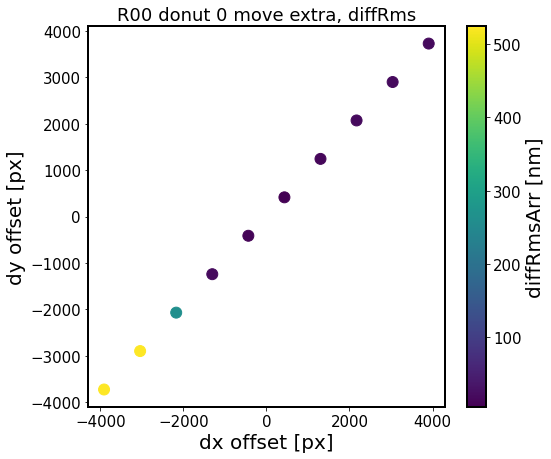

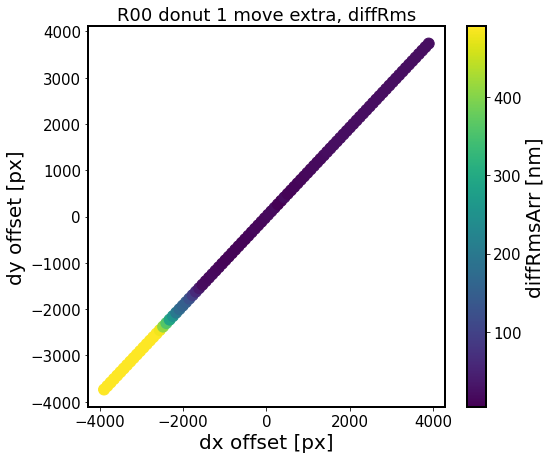

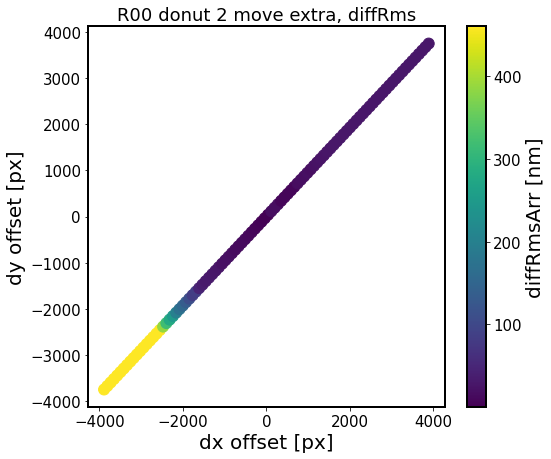

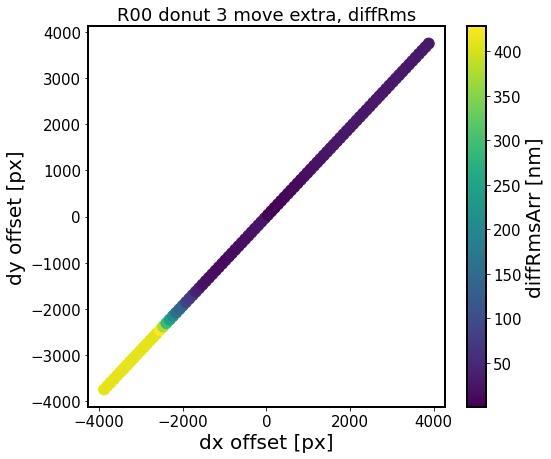

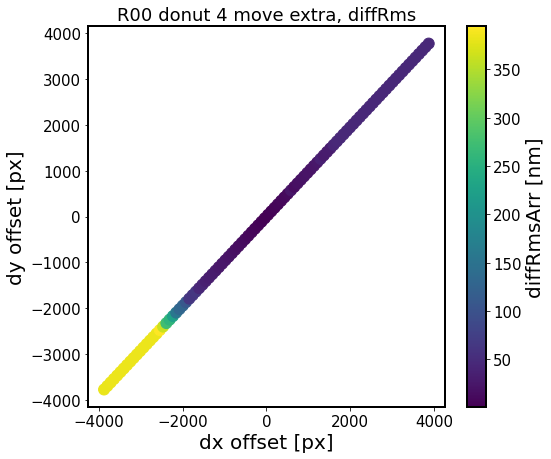

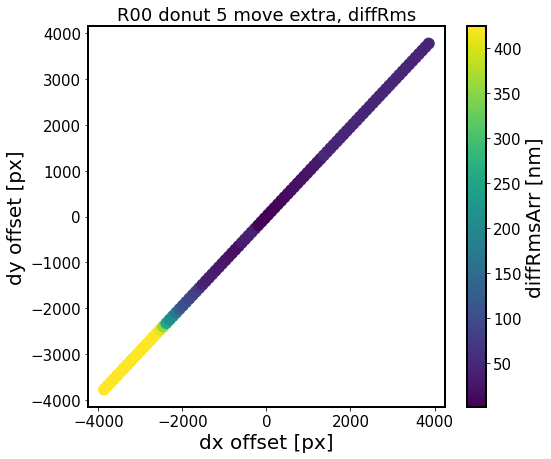

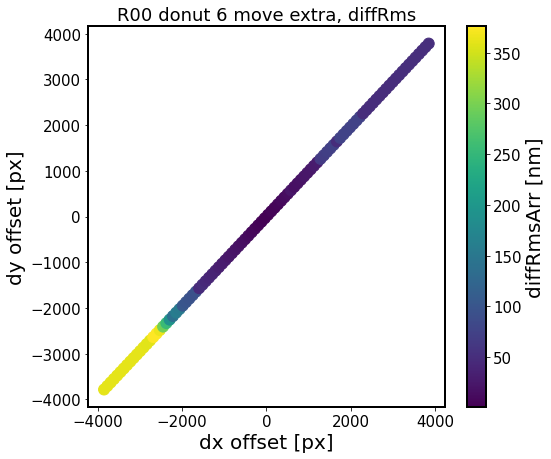

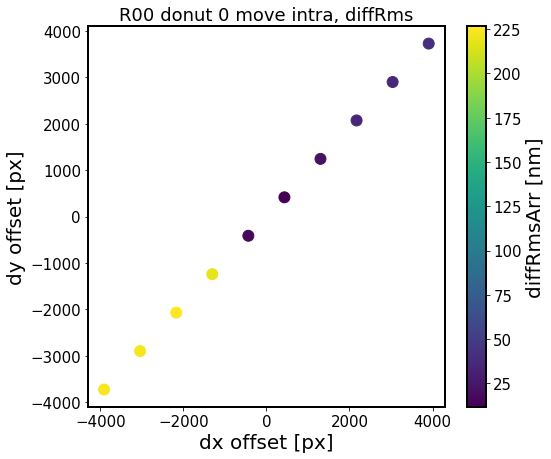

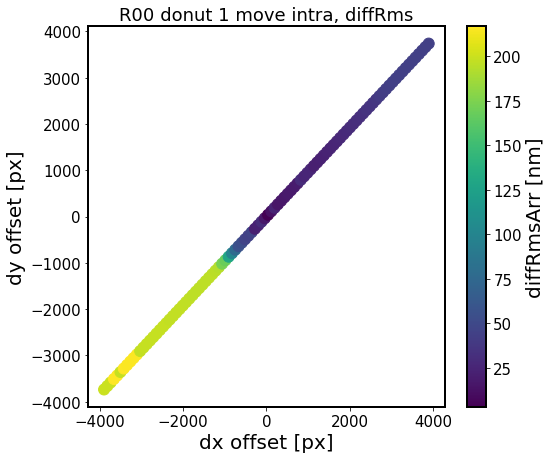

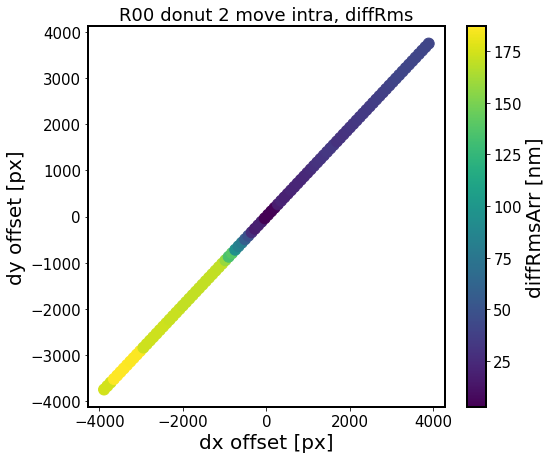

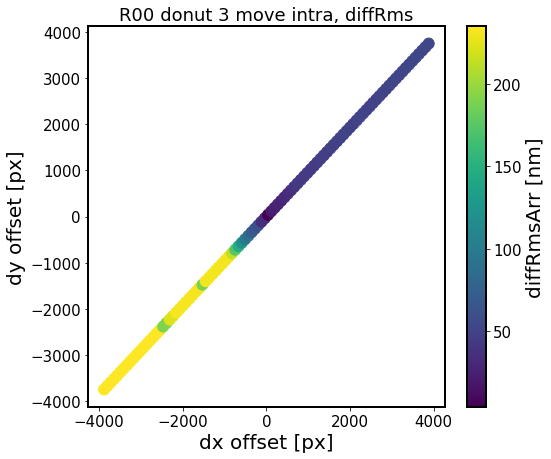

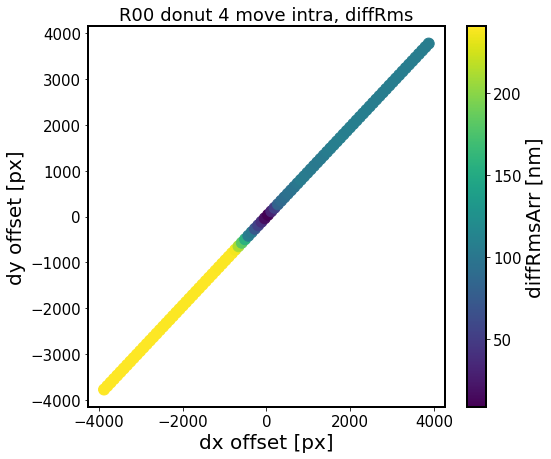

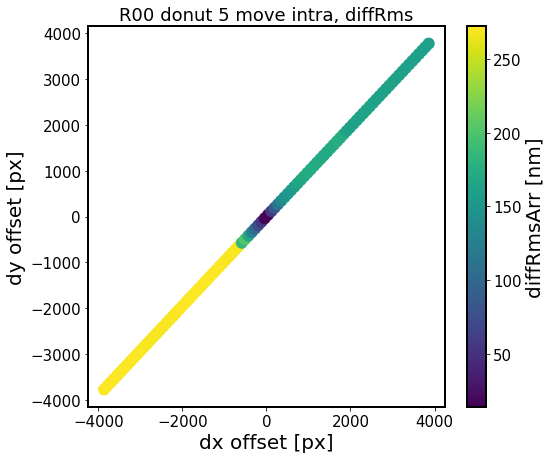

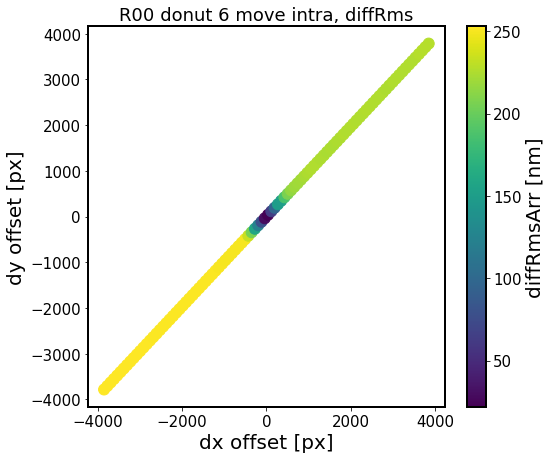

In [103]:
sensor = 'R00'
for defocal in ['extra','intra']:
    for i in range(7):

        fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_radial.npy'
        #fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
        results = np.load(fname, allow_pickle=True).item()


        diffMaxArr = []
        diffRmsArr = []
        dxPxArr = []
        dyPxArr = []

        # convert the dx, dy in degrees to pixels 
        for j in results.keys():
            dxPx = results[j]['dxPx']
            dyPx = results[j]['dyPx'] 

            dxPxArr.append(dxPx)
            dyPxArr.append(dyPx)

            # calculate max difference and rms difference 
            # just like in test_multImgs.py for ts_wep 
            diffMax = results[j]['diffMax']
            diffRms = results[j]['diffRms']
            diffMaxArr.append(diffMax)
            diffRmsArr.append(diffRms)



        # plot 
        fig,ax = plt.subplots(1,1,figsize=(8,7))
        #N = 100
        sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr,s=120)
        #ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
        ax.set_xlabel('dx offset [px]')
        ax.set_ylabel('dy offset [px]')
        ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
        plt.colorbar(sc, label = 'diffRmsArr [nm]')




For each, calculate the number of pixels in the mask different from the baseline mask, as well as N pixels  * image value. This is possible because at each stage I stored the compensable image 

check the baseline image masks 

In [59]:
m1 = results[0]['imgExtra'].getNonPaddedMask()
m2 = results[33]['imgExtra'].getNonPaddedMask()
np.sum(m1-m2)


0

In [60]:
m1 = results[0]['imgIntra'].getNonPaddedMask()
m2 = results[33]['imgIntra'].getNonPaddedMask()
np.sum(m1-m2)


0

In [61]:
m1 = results[0]['imgIntra'].getImg()
m2 = results[33]['imgIntra'].getImg()
np.sum(m1-m2)

0.0

In [105]:
results

{0: {'dxDeg': -0.2166087483243624,
  'dxPx': -3898.957469505209,
  'dyDeg': -0.2075587872130522,
  'dyPx': -3736.0581695155515,
  'drDeg': -0.3,
  'drPx': -5399.999999538364,
  'imgExtra': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff791213c10>,
  'imgIntra': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff791213af0>,
  'diffMax': 558.26113149551,
  'diffRms': 200.16902838058178,
  'zk': array([-551.42119742,  420.21431499,  299.53972012, -132.47261654,
         -264.14268275,  510.51388733, -184.60399665,   -6.21435205,
           -6.29582271,   41.18694122,  155.96046293, -171.28199119,
           30.44828368,   -1.55339899,    1.46928827,  -13.72869064,
          -54.79313483,  -31.30956626,   10.34617849]),
  'imgExtraFieldXY': (-1.1945833333333333, -1.1243888888888889),
  'imgIntraFieldXY': (-1.4276920816576955, -1.4714476761019408)},
 1: {'dxDeg': -0.21223281401477934,
  'dxPx': -3820.1906519394474,
  'dyDeg': -0.20336568040066738,
  'dyPx': -3660.58224

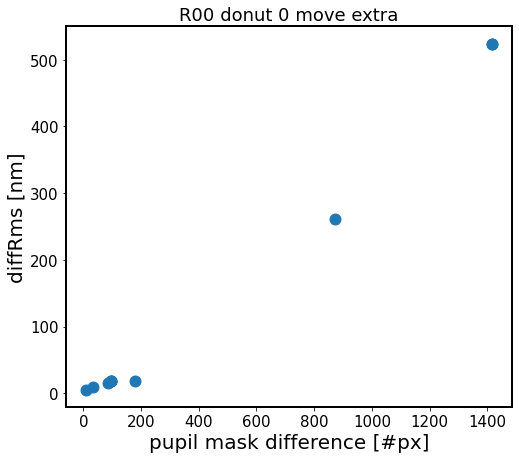

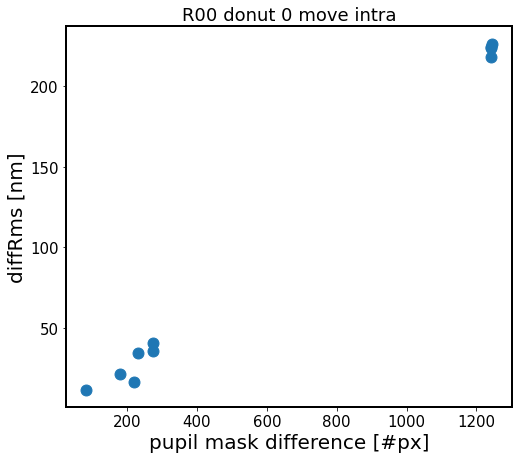

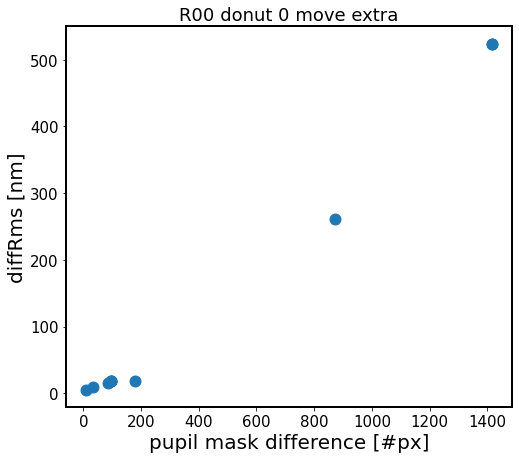

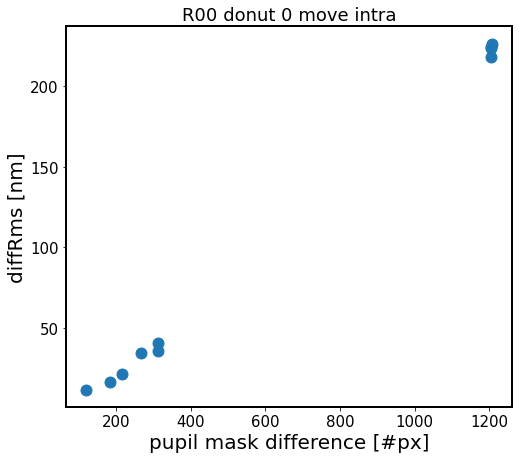

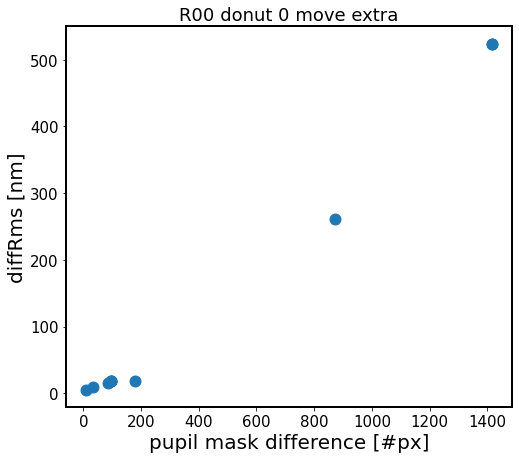

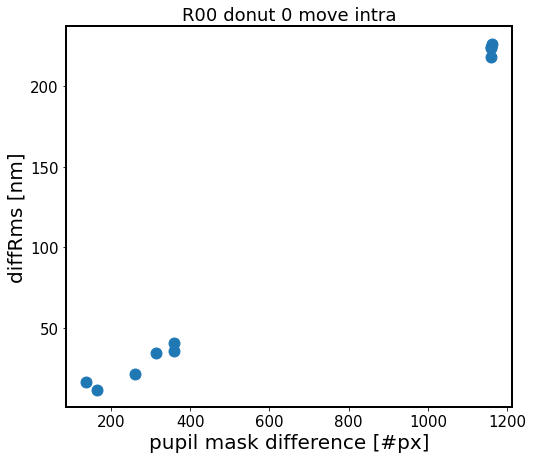

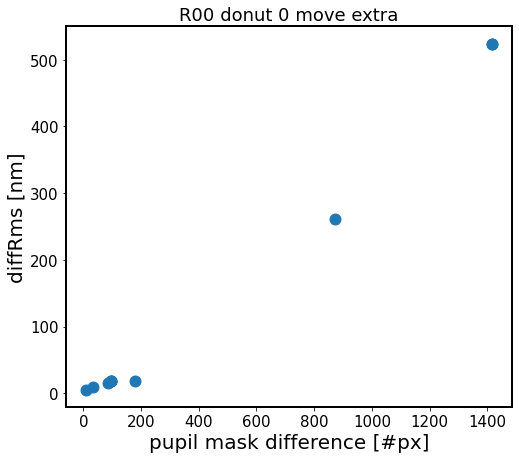

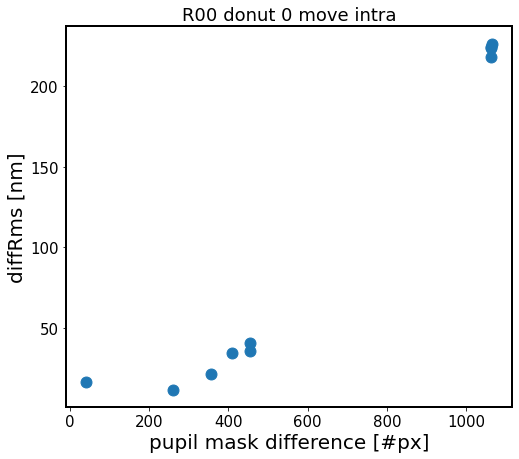

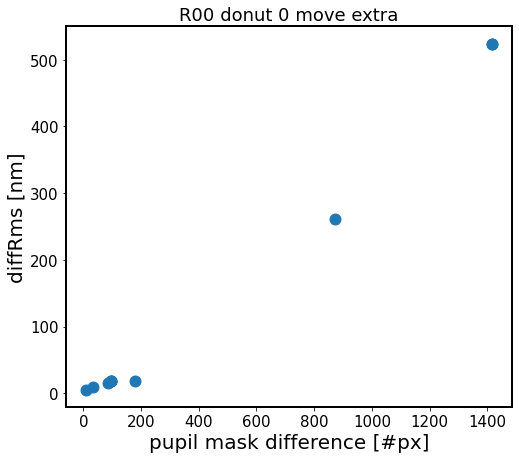

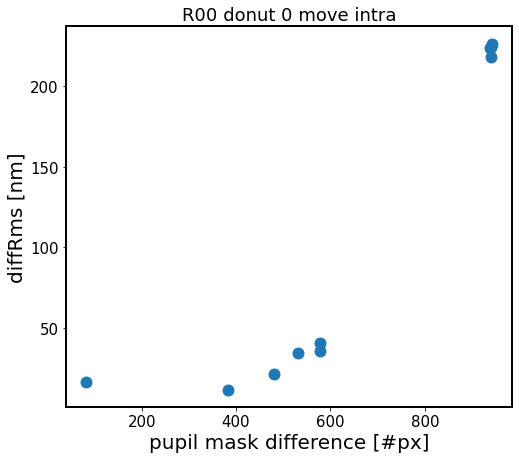

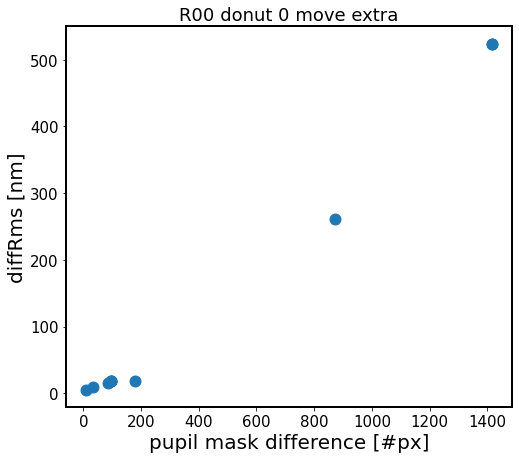

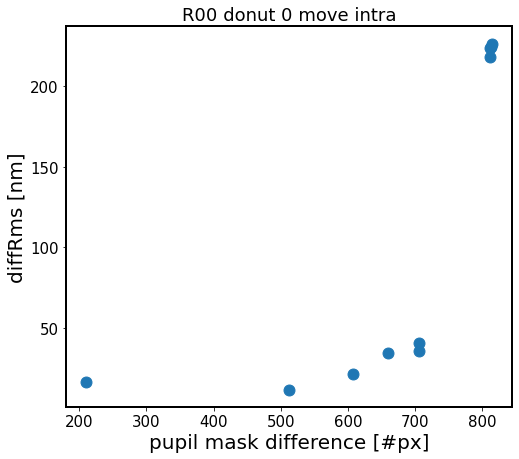

In [124]:
sensor = 'R00'

sensor = 'R00'

for i in range(6):
    fname = f'{sensor}_donut_{i}_no_offset_zk.npy'
    baseline =  np.load(fname, allow_pickle=True).item()

    #efocal = 'tra'
    for defocal in ['extra','intra']:

        half = defocal.capitalize()

        mp0 = baseline[f'img{half}'].getNonPaddedMask()
        mc0 =  baseline[f'img{half}'].getPaddedMask()
        img0 = baseline[f'img{half}'].getImg()

        i=0#for i in range(7):
        fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_radial.npy'
        results = np.load(fname, allow_pickle=True).item()

        diffMaxArr = []
        diffRmsArr = []
        mcDiffArr = []
        mpDiffArr = []

        for j in results.keys():

            diffMax = results[j]['diffMax']
            diffRms = results[j]['diffRms']
            diffMaxArr.append(diffMax)
            diffRmsArr.append(diffRms)

            mp =  results[j][f'img{half}0mp']
            mc =  results[j][f'img{half}0mc']
            img = results[j][f'img{half}0img']

            # calculate mask difference 
            mcDiffArr.append(np.sum(mc-mc0))
            mpDiffArr.append(np.sum(mp-mp0))

        # plot 
        fig,ax = plt.subplots(1,1,figsize=(8,7))
        #N = 100
        sc = ax.scatter(np.abs(mpDiffArr), diffRmsArr , s=120)
        ax.set_xlabel('pupil mask difference [#px]')
        ax.set_ylabel('diffRms [nm]')
        ax.set_title(f'{sensor} donut {i} move {defocal}')

Why are all compensable images identical ? Doesn't make sense... 

In [52]:
mpDiffArr

[856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856,
 856]

In [25]:





#mcDiffImg
#mpDiffImg

In [33]:
np.sum(mc0-mc)

-66

In [32]:
np.sum((mc0-mc)*img0)

0.0

In [27]:
np.sum(mp0-mp)

-97

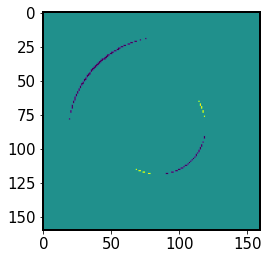

In [28]:
plt.imshow(mp0-mp)

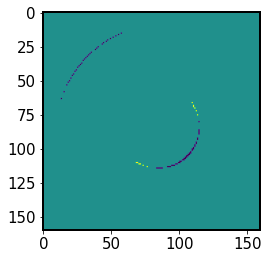

In [29]:
plt.imshow(mc0-mc)

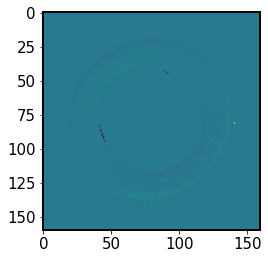

In [30]:
plt.imshow(img-img0)

In [3]:
results[10]['imgIntra']

{'dxDeg': -0.17078705118941984,
 'dxPx': -3074.1669211467524,
 'dyDeg': -0.16775351371751235,
 'dyPx': -3019.563246657086,
 'drDeg': -0.23939393939393938,
 'drPx': -4309.090908722533,
 'imgExtra': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff79e951ae0>,
 'imgIntra': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7ff79e9519c0>,
 'diffMax': 798.5742228746118,
 'diffRms': 252.93210509674773,
 'zk': array([-569.35723181,  316.07783025,  236.96264994, -198.23659551,
        -237.12638629,  529.99494501, -158.98774361,    1.4873517 ,
         -12.39010608,   46.31990108,  181.49342959, -179.09496932,
          27.52560115,   14.58623593,    9.15580943,  -23.35411246,
         -70.93828728,   -4.02782007,    9.39887382]),
 'imgExtraFieldXY': (-1.1945833333333333, -1.1243888888888889),
 'imgIntraFieldXY': (-1.4319259400783086, -1.4516979581619567)}

## Calculate circle of diffRms ... 

In [55]:
#################################
### STEP 1 :  Load the stamps
#################################

repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# now instead of calling 
# wfEsti = WfEstimator(instDir, algoDir)
# I dig inside it 

# this is part of the init 
inst = Instrument(instDir)
algo = Algorithm(algoDir)

#imgIntra = CompensableImage()
#imgExtra = CompensableImage()

#opticalModel = ""
#sizeInPix = 0

# now get the camera type and defocal distance
# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
# https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L134
instName='lsst'    
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# now instead of calling 
# wfEsti.config( sizeInPix=self.donutStampSize, camType=camType,
#                opticalModel=self.opticalModel, defocalDisInMm=defocalDisInMm,
# )

# I update the parameters 
opticalModel = 'offAxis'
# Update the instrument name
#donutStampSize = 160 # px 
#sizeInPix = donutStampSize
sizeInPix = 160# int(sizeInPix)

inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm 
solver = 'exp' # by default 
debugLevel=0 # 1 to 3 
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)


In [ ]:
###
# now we'd normally loop over donut images 
### 

# here loop only over intra-focal, as those are the ones with 
# increasing vignetting ... 

for i in range(1,5):#len(donutStampsIntra)):
    #for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
    donutExtra = donutStampsExtra[0]
    donutIntra = donutStampsIntra[i]
    
    print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')
    fieldXYExtra = donutExtra.calcFieldXY()
    fieldXYIntra = donutIntra.calcFieldXY()

    camera = donutExtra.getCamera() # same camera for both donuts 
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)


    # Rotate any sensors that are not lined up with the focal plane.
    # Mostly just for the corner wavefront sensors. The negative sign
    # creates the correct rotation based upon closed loop tests
    # with R04 and R40 corner sensors.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # Now instead of running `wfEsti.setImg` method, do it by hand, since 
    # it inherits 'setImg' from 'CompensableImage' anyway...


    #####################################
    # Step 2 : baseline fit (no offset)
    #####################################
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

    boundaryT = algo.getBoundaryThickness()

    # right after we set the image, the compensable image mask is empty - 
    # it is only calculated in algo
    # https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
    maskScalingFactorLocal = 1
    imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
    imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)


    # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
    algo.reset()

    # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
    # simply calls algo:
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
    zk_no_offset = algo.getZer4UpInNm()
    fname = f'VignettingAllSky_{sensor}_donut_{i}_no_offset_zk.txt'
    np.savetxt(fname, zk_no_offset)
    print(f'\nSaved the baseline fit as {fname}')
    
    #####################################
    # Step 3 :  circle of diffRms , for `intra` and `extra` offsets....
    #####################################
    
    for defocal in ['intra','extra']: # or extra 
        print(f'Fitting {sensor} donut {i} shifting {defocal} centroid ')
        zk0 = zk_no_offset

        # starting boundary conditions 
        thetaRad = 0 # radians
        dthetaRad = 0.2 # radians ~ 11.45 deg 
        drPxStep = 2 # pixels 

        diffRmsThresh = 1.0 # nm 

        results = {}

        j=0
        # iterate over a range of angles 
        for thetaRad in np.arange(0,2*np.pi, dthetaRad):

            # always start from 0 radius ... 
            drPx = 0 # px 
            diffRms = 0 # nm 

            # increase radius until threshold is reached 
            while diffRms < diffRmsThresh:

                dxPx = drPx*np.cos(thetaRad)
                dyPx = drPx*np.sin(thetaRad)

                dxDeg = (dxPx * pixelScale) / 3600.
                dyDeg = (dyPx * pixelScale) / 3600.

                results[j]={'dxPx':dxPx, 'dyPx':dyPx, 'dxDeg':dxDeg, 'dyDeg':dyDeg,
                           'drPx':drPx, }
                #print(j, drPx, thetaRad, diffRms)

                # do the fit 
                if defocal == 'extra':
                    fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, fieldXYExtra[1]+dyDeg)
                    fieldXYIntraUpd = fieldXYIntra

                elif defocal =='intra':
                    fieldXYExtraUpd = fieldXYExtra
                    fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, fieldXYIntra[1]+dyDeg)

                imgExtra.setImg(fieldXYExtraUpd,
                                DefocalType.Extra,
                                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

                imgIntra.setImg(fieldXYIntraUpd,
                                DefocalType.Intra,
                                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

                # calculate the mask 
                maskScalingFactorLocal = 1
                boundaryT = algo.getBoundaryThickness()
                imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
                imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

                # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
                algo.reset()

                # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
                # simply calls algo:
                tol = 1e-3 # explicitly set the tolerance level ( this is default )
                algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
                zk = algo.getZer4UpInNm()
                results[j]['zk'] = zk


                # calculate diffMax, diffRms
                diffMax = np.max(np.abs(zk - zk0))
                diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

                # store the results 
                results[j]['diffMax'] = diffMax
                results[j]['diffRms'] = diffRms
                results[j]['zk'] = zk
                results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
                results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()

                # increase the radius
                drPx += drPxStep 

                # increase the counter 
                j += 1
            print(j-1, drPx, thetaRad, diffRms) 
            print('Threshold reached at radius ', drPx)  


        # store the results  for  shifting the extra-focal donut or 
        # shifting the intra-focal donut 
        fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
        print(f"saved {fname}")
        np.save(fname, results)
        
    # increase donut counter 
    i += 1 


 Fitting sensor R00, donutIntra 1, donutExtra 0 

Saved the baseline fit as VignettingAllSky_R00_donut_1_no_offset_zk.txt
Fitting R00 donut 1 shifting intra centroid 
6 14 0.0 1.269164709506493
Threshold reached at radius  14
12 12 0.2 1.3028490698735014
Threshold reached at radius  12
17 10 0.4 1.3024641926518528
Threshold reached at radius  10
22 10 0.6000000000000001 1.3018661033240135
Threshold reached at radius  10
27 10 0.8 1.3015601759295286
Threshold reached at radius  10
29 4 1.0 15.48743904388613
Threshold reached at radius  4
31 4 1.2000000000000002 15.487332203443863
Threshold reached at radius  4
33 4 1.4000000000000001 15.48734319070304
Threshold reached at radius  4
35 4 1.6 15.487471718375112
Threshold reached at radius  4
37 4 1.8 15.487713990410784
Threshold reached at radius  4
39 4 2.0 15.488058256913302
Threshold reached at radius  4
41 4 2.2 15.488491488817639
Threshold reached at radius  4
43 4 2.4000000000000004 15.48899755853541
Threshold reached at radius  4


992 90 3.8000000000000003 1.01959236647699
Threshold reached at radius  90
1037 90 4.0 1.0192237711109913
Threshold reached at radius  90
1082 90 4.2 1.0000073191075851
Threshold reached at radius  90
1129 94 4.4 1.0066267944286627
Threshold reached at radius  94
1179 100 4.6000000000000005 1.0157536842158579
Threshold reached at radius  100
1232 106 4.800000000000001 1.0102515230978681
Threshold reached at radius  106
1289 114 5.0 1.0168383885795755
Threshold reached at radius  114
1349 120 5.2 1.0137281797923716
Threshold reached at radius  120
1410 122 5.4 1.000089603231111
Threshold reached at radius  122
1471 122 5.6000000000000005 1.006607420709345
Threshold reached at radius  122
1530 118 5.800000000000001 1.0137992550273314
Threshold reached at radius  118
1585 110 6.0 1.003952487171851
Threshold reached at radius  110
1637 104 6.2 1.0145126375745257
Threshold reached at radius  104
saved VignettingAllSky_R00_donut_2_move_extra_results_circle_finer.npy

 Fitting sensor R00, don

Plot results

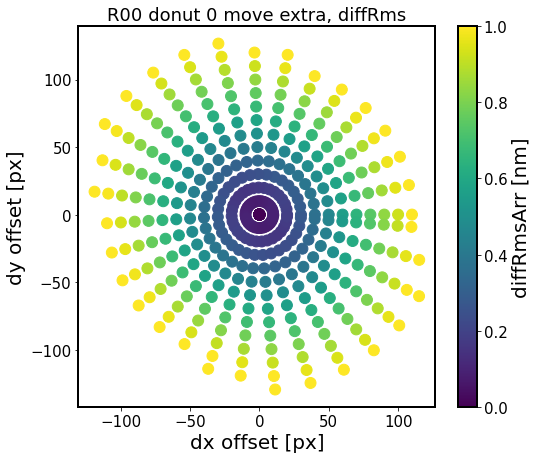

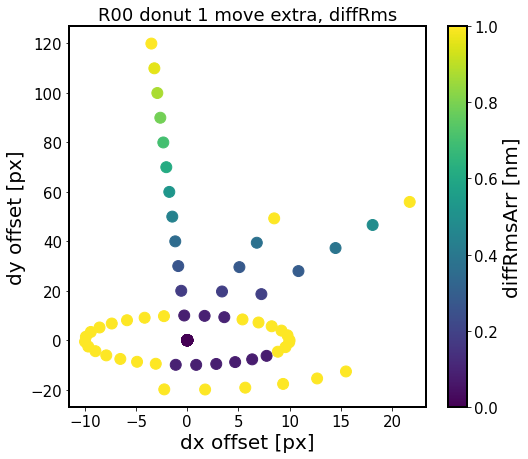

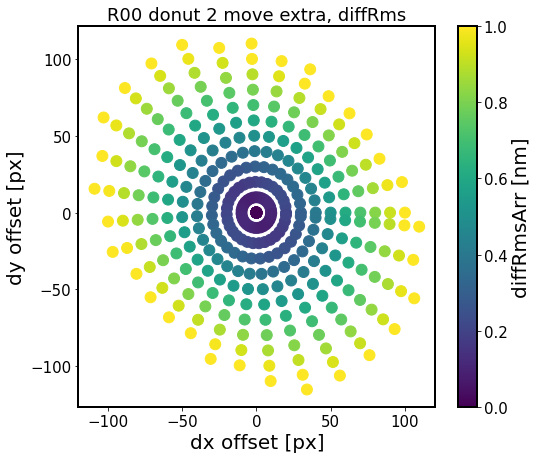

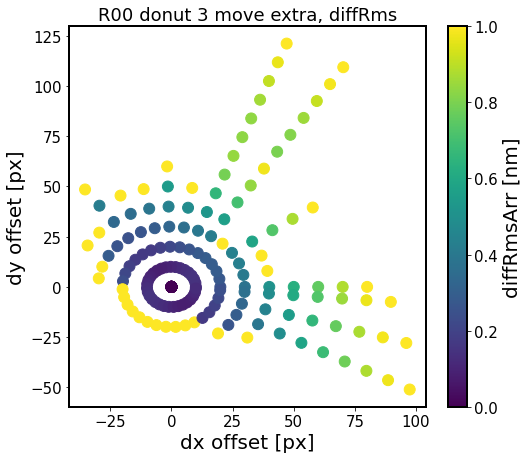

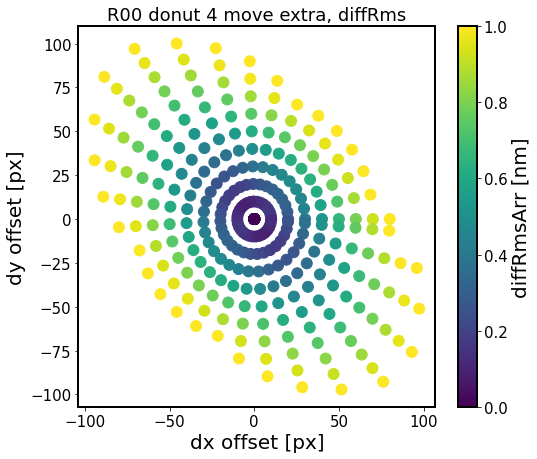

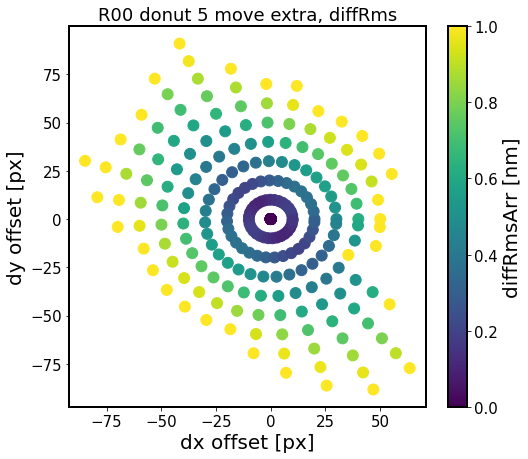

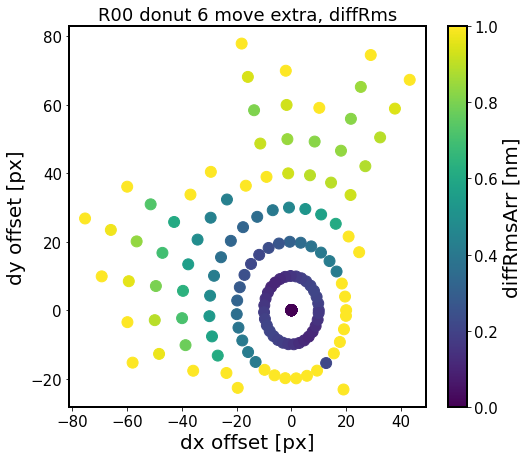

In [23]:
sensor = 'R00'
for i in range(7):
    defocal = 'extra'
    fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle.npy'
    #fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
    results = np.load(fname, allow_pickle=True).item()


    diffMaxArr = []
    diffRmsArr = []
    dxPxArr = []
    dyPxArr = []

    # convert the dx, dy in degrees to pixels 
    for j in results.keys():
        dxPx = results[j]['dxPx']
        dyPx = results[j]['dyPx'] 

        dxPxArr.append(dxPx)
        dyPxArr.append(dyPx)

        # calculate max difference and rms difference 
        # just like in test_multImgs.py for ts_wep 
        diffMax = results[j]['diffMax']
        diffRms = results[j]['diffRms']
        diffMaxArr.append(diffMax)
        diffRmsArr.append(diffRms)



    # plot 
    fig,ax = plt.subplots(1,1,figsize=(8,7))
    #N = 100
    sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, vmax=1.,s=120)
    #ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
    ax.set_xlabel('dx offset [px]')
    ax.set_ylabel('dy offset [px]')
    ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
    plt.colorbar(sc, label = 'diffRmsArr [nm]')




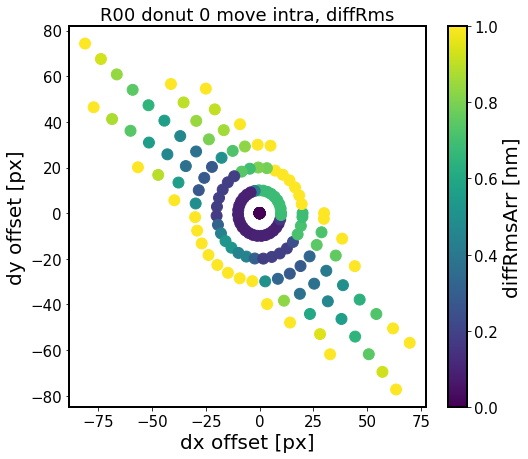

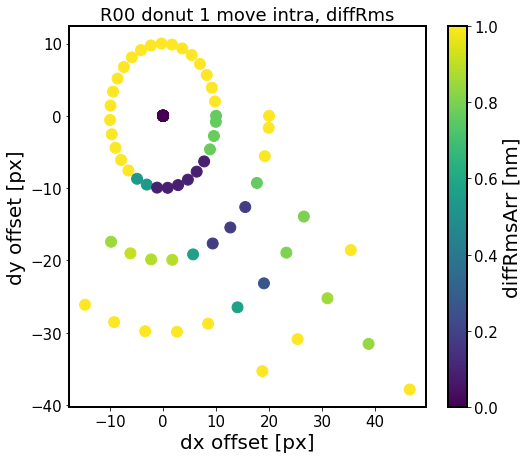

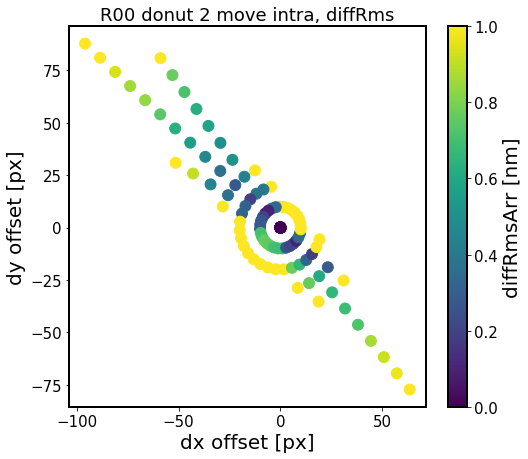

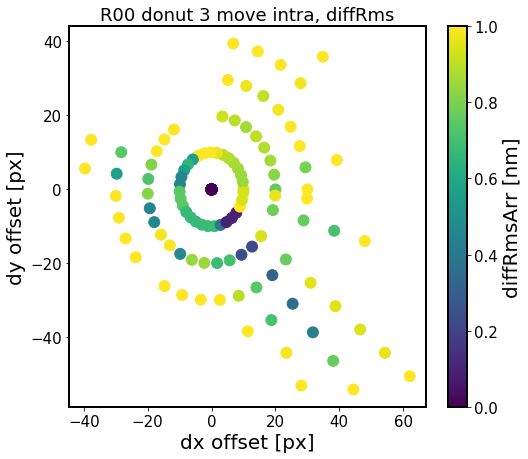

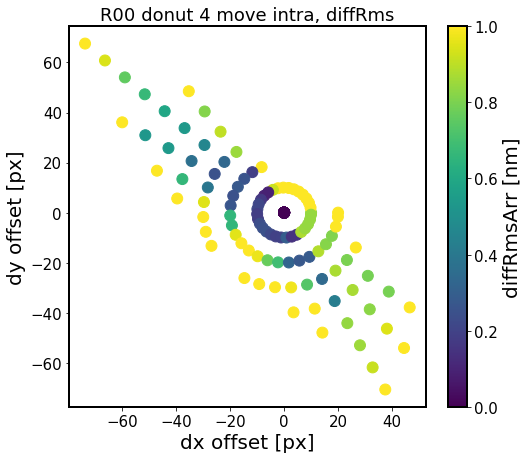

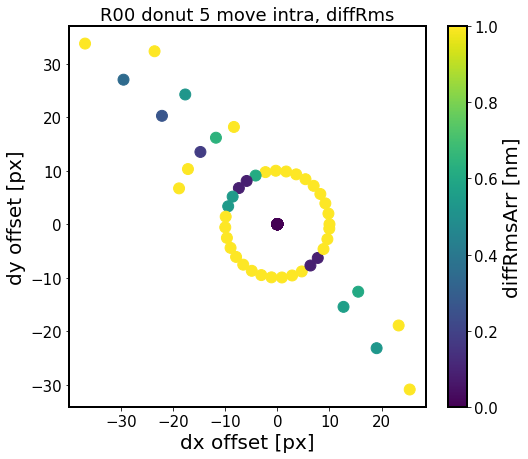

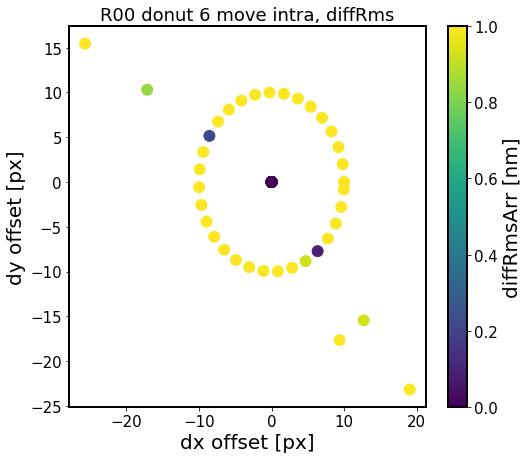

In [24]:
sensor = 'R00'
for i in range(7):
    defocal = 'intra'
    fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle.npy'
    #fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
    results = np.load(fname, allow_pickle=True).item()


    diffMaxArr = []
    diffRmsArr = []
    dxPxArr = []
    dyPxArr = []

    # convert the dx, dy in degrees to pixels 
    for j in results.keys():
        dxPx = results[j]['dxPx']
        dyPx = results[j]['dyPx'] 

        dxPxArr.append(dxPx)
        dyPxArr.append(dyPx)

        # calculate max difference and rms difference 
        # just like in test_multImgs.py for ts_wep 
        diffMax = results[j]['diffMax']
        diffRms = results[j]['diffRms']
        diffMaxArr.append(diffMax)
        diffRmsArr.append(diffRms)



    # plot 
    fig,ax = plt.subplots(1,1,figsize=(8,7))
    #N = 100
    sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, vmax=1.,s=120)
    #ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
    ax.set_xlabel('dx offset [px]')
    ax.set_ylabel('dy offset [px]')
    ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
    plt.colorbar(sc, label = 'diffRmsArr [nm]')




Plot just the baseline for all donuts, what's specific about 1,3,5,6 ? 

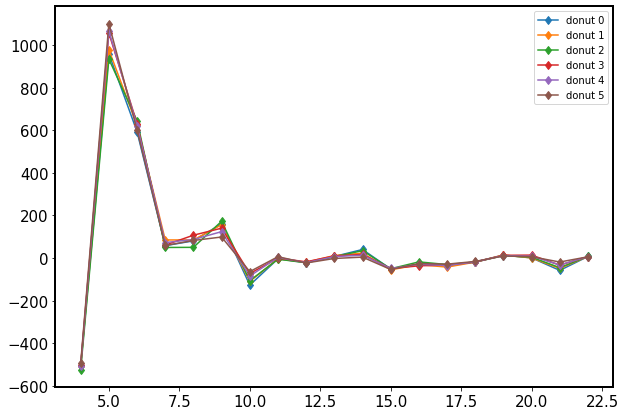

In [25]:
# plot all donuts in that simulation....
fig,ax = plt.subplots(1,1,figsize=(10,7))
#ax.set_title(radialOffsetDegrees)
for i in range(6):
    fname =  f'VignettingAllSky_{sensor}_donut_{i}_no_offset_zk.txt'
    zk0 = np.loadtxt(fname,)
    
    ax.plot(np.arange(4, 23), zk0 ,'-d', label=f'donut {i}' )
    #ax.plot(np.arange(4, 23), results[175]['zk'] ,'-d', color = 'blue', )
ax.legend()


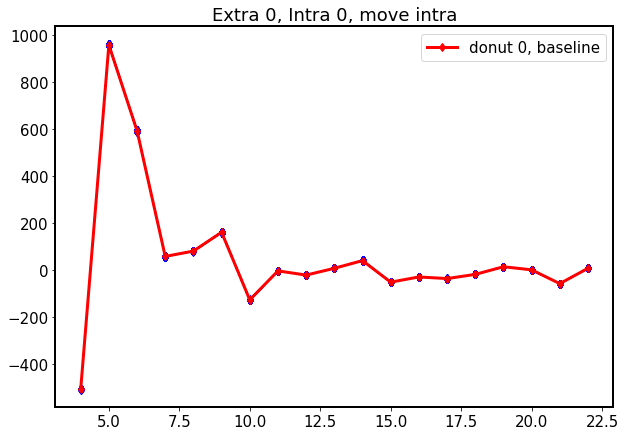

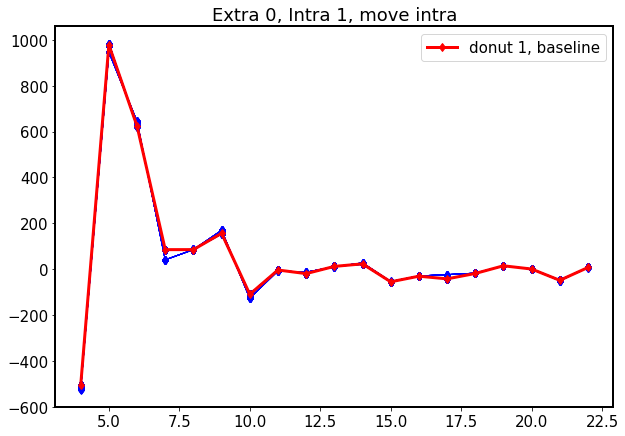

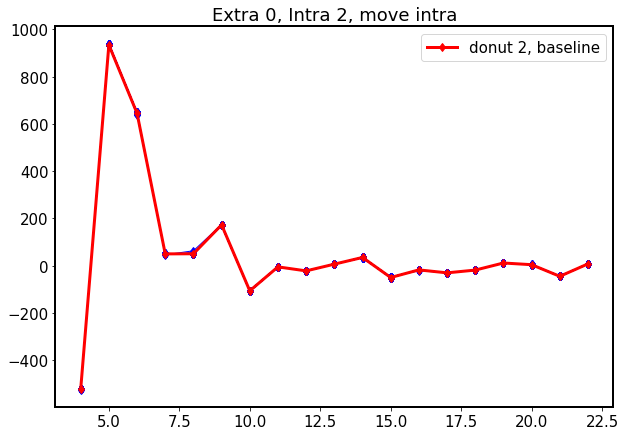

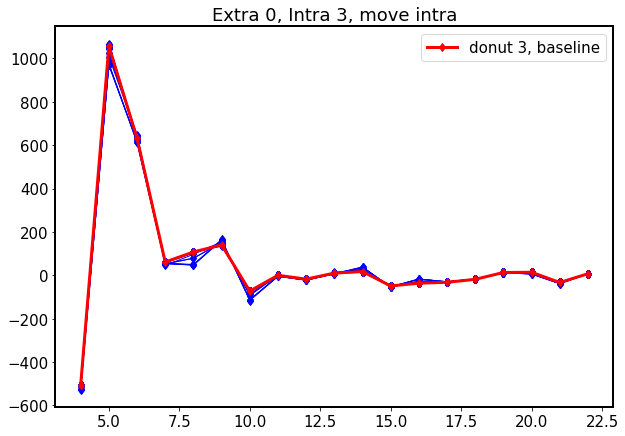

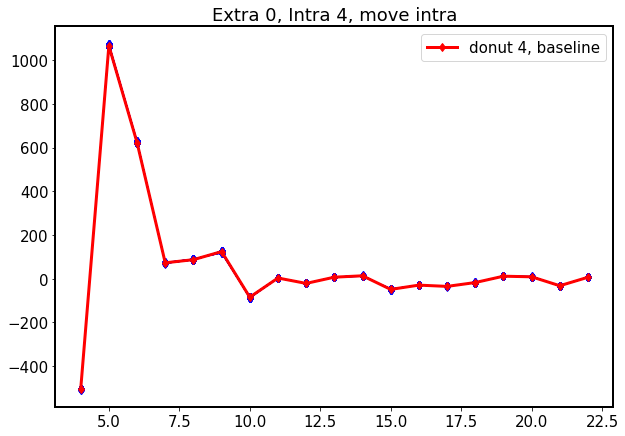

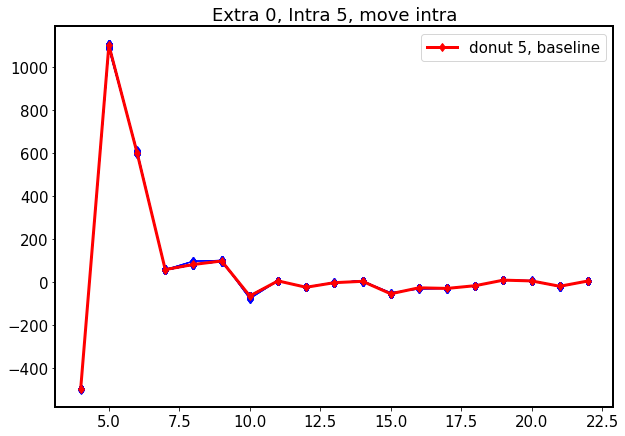

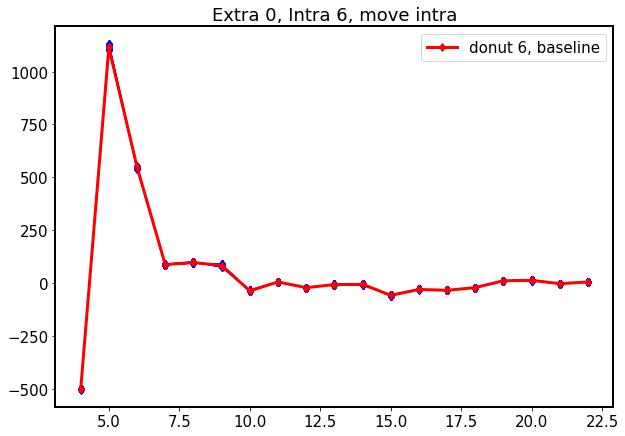

In [53]:
# plot for  donut 1,3,6, what  happens with small displacement?
for i in range(7):
    fig,ax = plt.subplots(1,1,figsize=(10,7))
    #ax.set_title(radialOffsetDegrees)
    #i = 3  #for i in range(6):
    fname =  f'VignettingAllSky_{sensor}_donut_{i}_no_offset_zk.txt'
    zk0 = np.loadtxt(fname,)

    # plot the offsets
    defocal = 'intra'
    fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle.npy'
    #fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
    results = np.load(fname, allow_pickle=True).item()
    for j in range(len(results)):
        zk = results[j]['zk']
        ax.plot(np.arange(4, 23), zk ,'-d', c='b', lw=1, )#label=f'donut {i}, offset ' )
    ax.set_title(f'Extra 0, Intra {i}, move {defocal}')
    # plot the baseline 
    ax.plot(np.arange(4, 23), zk0 ,'-d', lw=3, c='r', label=f'donut {i}, baseline' )
    #ax.plot(np.arange(4, 23), results[175]['zk'] ,'-d', color = 'blue', )
    ax.legend(fontsize=15)

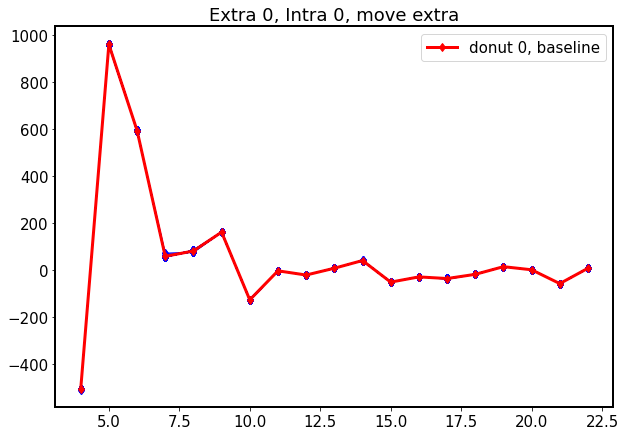

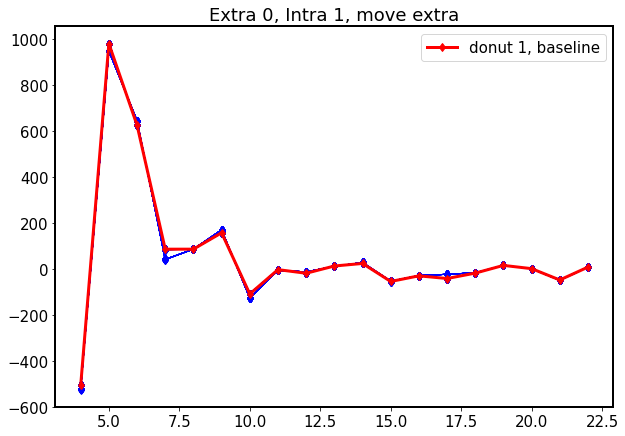

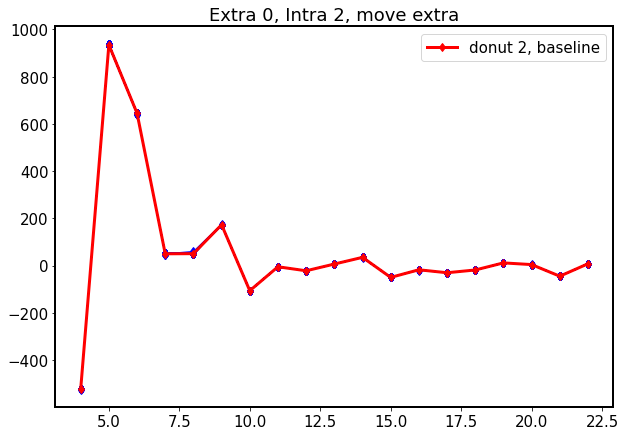

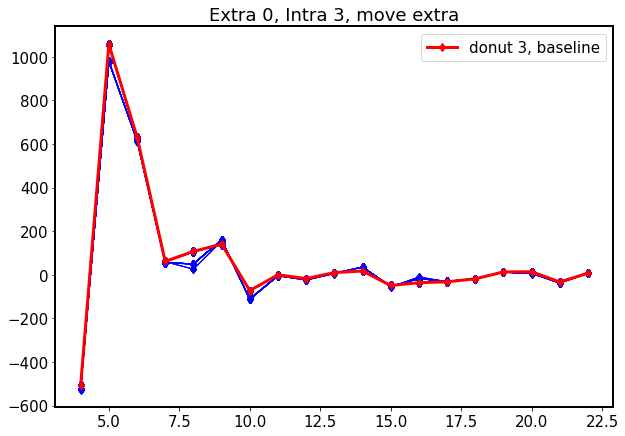

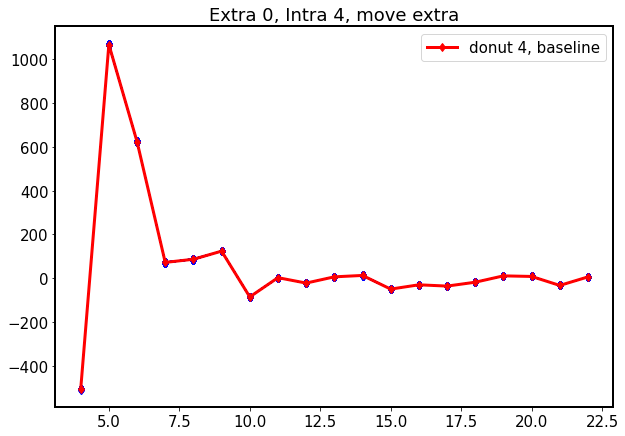

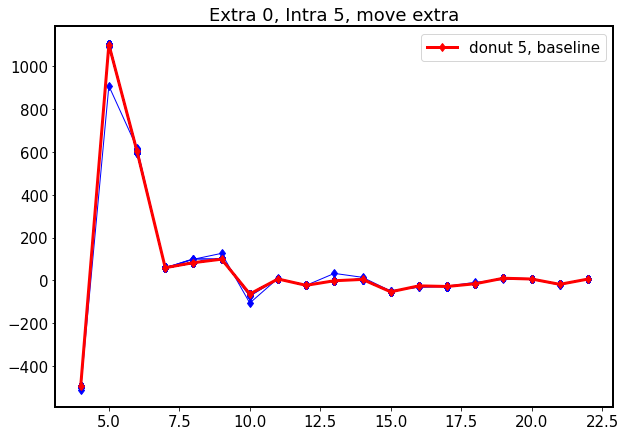

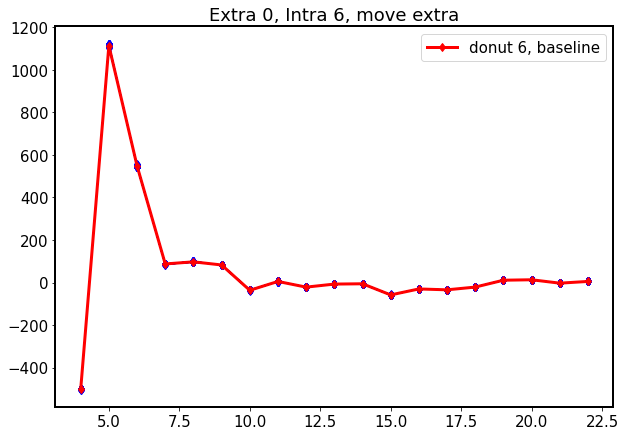

In [54]:
# plot for  donut 1,3,6, what  happens with small displacement?
for i in range(7):
    fig,ax = plt.subplots(1,1,figsize=(10,7))
    #ax.set_title(radialOffsetDegrees)
    #i = 3  #for i in range(6):
    fname =  f'VignettingAllSky_{sensor}_donut_{i}_no_offset_zk.txt'
    zk0 = np.loadtxt(fname,)

    # plot the offsets
    defocal = 'extra'
    fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle.npy'
    #fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
    results = np.load(fname, allow_pickle=True).item()
    for j in range(len(results)):
        zk = results[j]['zk']
        ax.plot(np.arange(4, 23), zk ,'-d', c='b', lw=1, )#label=f'donut {i}, offset ' )
    ax.set_title(f'Extra 0, Intra {i}, move {defocal}')
    # plot the baseline 
    ax.plot(np.arange(4, 23), zk0 ,'-d', lw=3, c='r', label=f'donut {i}, baseline' )
    #ax.plot(np.arange(4, 23), results[175]['zk'] ,'-d', color = 'blue', )
    ax.legend(fontsize=15)